In [47]:
import pandas as pd
import numpy as np

values = {'trials': [1,1,2,2,3,3],
        'times': [200,400,600,200,400,600], 
        'cells': [1,1,1,2,2,2],
        'spikes': [.5,0,5,.2,.1,10]
        }

df = pd.DataFrame(values)


In [48]:
def shuffle_cells(df):
    df1 = pd.DataFrame(columns=['trials','times','cells','spikes'])
    for i in range(1,3):
        cell_i = df[df["cells"] == i]
        cell_i["spikes"] = np.random.permutation(cell_i["spikes"])
        df1 = df1.append(cell_i, ignore_index=True)
    return df1

        
max_spike = {}
shuffled_spike = {}
for i in range(0,5):
    df1 = shuffle_cells(df)
    for i, j in df1.iterrows():
        time = int(j["times"])
        cell = int(j["cells"])
        spike = float(j["spikes"])
        if (time, cell) in shuffled_spike:
            shuffled_spike[(time,cell)].append(spike)
        else:
            shuffled_spike[(time,cell)] = []
            shuffled_spike[(time,cell)].append(spike)       
    for k,v in shuffled_spike.items():
        max_spike[k] = max(v)
            
print(shuffled_spike)  
print(max_spike)

{(200, 1): [5.0, 0.0, 0.5, 5.0, 0.5], (400, 1): [0.5, 5.0, 0.0, 0.0, 0.0], (600, 1): [0.0, 0.5, 5.0, 0.5, 5.0], (200, 2): [10.0, 0.2, 10.0, 0.2, 0.1], (400, 2): [0.2, 0.1, 0.2, 0.1, 10.0], (600, 2): [0.1, 10.0, 0.1, 10.0, 0.2]}
{(200, 1): 5.0, (400, 1): 5.0, (600, 1): 5.0, (200, 2): 10.0, (400, 2): 10.0, (600, 2): 10.0}


/home/sophia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [50]:
from scipy import stats

time_cells = {}
for i, j in df.iterrows():
        time = int(j["times"])
        cell = int(j["cells"])
        spike = float(j["spikes"])
        trial = int(j["trials"])
        arr = np.array(shuffled_spike[(time,cell)])
        print(arr)
        st_dev = np.std(arr)
        z_scores = stats.zscore(arr)
        res = dict(zip(arr, z_scores)) 
        nintey_fifth_p = np.percentile(arr, 95)
        if spike > nintey_fifth_p:
            z_score = res[spike]
            if spike > z_score + std_dev:
                if cell in time_cells:
                    time_cells[(time, cell)] += 1
                else:
                    time_cells[(time,cell)] = 1
                    
print(time_cells)

[5.  0.  0.5 5.  0.5]
[0.5 5.  0.  0.  0. ]
[0.  0.5 5.  0.5 5. ]
[10.   0.2 10.   0.2  0.1]
[ 0.2  0.1  0.2  0.1 10. ]
[ 0.1 10.   0.1 10.   0.2]
{}


In [52]:
import pandas as pd
import numpy as np
import time as t

# Things to set:
#filename = 'wfC318/Day_4/raw_files_csv/combined_behavior_and_s_COPY.csv'
filename = 'wfC318/Day_4/raw_files_csv/combined_behavior_and_s.csv'
#filename = 'wfC318/Day_0/Raw_files_csv/combined_behavior_and_s.csv'

# How many trials we are looking at (ex: 31 for day 0, 34 for day 4)
trial_count = 31


data = pd.read_csv(filename, header=None)

# Will change neuron firing data to (0,1) binary indicators
data_for_freq = pd.read_csv(filename, header=None)

def changeTime(data_name):
    trial_prev, time_prev, end_time = 0,0,0
    for i, j in data_name.iterrows():
        trial = int(j[9])
        time = int(j[1])
        if trial != trial_prev:
            end_time = time_prev
        data_name.at[i,1] = time - end_time
        trial_prev = trial
        time_prev = time
    print("time changed")
    
changeTime(data)
changeTime(data_for_freq)



length = len(data)
data = data[data[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm
data_for_freq = data_for_freq[data_for_freq[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm


time = data[1]
odor = data[10]
distance = data[7]
lap = data[9]
# neuron data starts at column "13", indexed from 0 so the first column of neuron data is data[12]
cell = data.loc[:, 12:(len(data.columns)-1)]  # neuron data

#trial_count = max(lap)  # all of them



# using lambda function instead
def binaryIndicator(x):
    if x > 0:
        x = 1
    else:
        x = 0
    return x


# Using second copy of data to change neuron data to (0,1) to calculate 10% threshold
# Changing neuron firing data to 0,1 binary
num_of_cols = len(data_for_freq.columns)
for j in range(12, num_of_cols):  # for all neuron columns
    # setting value to 1 if val>0, 0 otherwise
    data_for_freq[j] = data_for_freq[j].apply(lambda x: 1 if (x > 0) else 0)
    #data_for_freq[j] = data_for_freq[j].apply(binaryIndicator)


lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    lap_dictionary[i] = data.loc[data[9] == i]  # associate all lap data with that lap


def findShortestTrial():
    min_time = 999999999
    max_time = 0
    shortest_trial = lap_dictionary[0]
    longest_trial = lap_dictionary[0]
    time_list = []
    for trial in lap_dictionary:
        #pair = lap_dictionary[trial].iloc[[0, -1]]
        first = lap_dictionary[trial].iloc[0]
        last = lap_dictionary[trial].iloc[-1]

        time = last[1] - first[1]
        time_list.append(time)

        if(time < min_time):
            min_time=time
            shortest_trial = trial
        if (time > max_time):
            max_time = time
            longest_trial = trial

    #print("AVG trial duration:", sum(time_list)/len(time_list))
    return shortest_trial, min_time, longest_trial, max_time

shortest_trial, min_time,longest_trial, max_time = findShortestTrial()
print("Shortest Trial:", shortest_trial, "Time: ", min_time)
print("Longest Trial:", longest_trial, "Time: ", max_time)


# Determining number of bins
num_of_time_bins = int(min_time // 200)
num_of_space_bins = 4000//100 # 100cm bin width 
print("number of time bins:", num_of_time_bins)


# create empty row to store neuron data frequencies
empty_row = {}
for k in range(0, num_of_cols-13):  # 255 or 459 columns for example
    empty_row[k] = 0.0

def findMeanValues():
    flagCounter = 0
    test_dictionary_for_laps = {}
    start = t.time()  # for reference
    for i in lap_dictionary:  # for every trial
        # print("Lap number:", i)
        # average columns in that trial to test (eventually, in bin instead)
        current_row = pd.DataFrame(empty_row, index=[0])  # create pandas dataframe from a row of 0's (reset every lap)
        #print(i)  # count 89~99 trial laps
        for j in range(12, num_of_cols):  # for all neuron columns
            #current_row[j - 12] = data[j].mean()
            current_row[j-12] = lap_dictionary[i][j].mean()  # fill each column spot in that row with the mean of all values in that column
            # note: because we set values to (0,1), this mean becomes frequency relative to that trial
        test_dictionary_for_laps[i] = current_row  # set dictionary item equal to that row

    end = t.time()
    #print("Time:", end-start)
    return test_dictionary_for_laps

test_dictionary_for_laps = findMeanValues()

"""
def changeTime():
    trial_prev, time_prev, end_time = 0,0,0
    for i, j in data.iterrows():
        trial = int(j[9])
        time = int(j[1])
        if trial != trial_prev:
            end_time = time_prev
        data.at[i,1] = time - end_time
        trial_prev = trial
        time_prev = time
    #print("Times changed")
#changeTime()
"""

NEW_lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    NEW_lap_dictionary[i] = data.loc[data[9] == i]  # associate all lap data with that lap
    #print(NEW_lap_dictionary[i].iloc[:,:13], "\n\n")
    

def timeBinning():
    # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in NEW_lap_dictionary:  # for every trial
        #print("TEST", NEW_lap_dictionary[i], "\n\n")
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        for bin_number in range(1, num_of_time_bins+1):
            bin_ending_time = bin_number*200
            last_time = (bin_number-1)*200
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = NEW_lap_dictionary[i].loc[(NEW_lap_dictionary[i][1] < bin_ending_time) & (NEW_lap_dictionary[i][1] >= last_time) ]
            list_of_bins[bin_ending_time] = data_points
            #print(data_points)
        dict_of_all_bins[i] = list_of_bins

    return dict_of_all_bins
binned_dic = timeBinning()
print("temporally binned dictionary")

def spaceBinning():
     # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in NEW_lap_dictionary:  # for every trial
        #print("TEST", NEW_lap_dictionary[i], "\n\n")
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        for bin_number in range(1, num_of_space_bins+1):
            bin_starting_dist = bin_number*100  # 10 cm bin width
            last_dist = (bin_number-1)*100
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = NEW_lap_dictionary[i].loc[(NEW_lap_dictionary[i][7] < bin_starting_dist) & (NEW_lap_dictionary[i][7] >= last_dist) ]
            list_of_bins[bin_starting_dist] = data_points
            #print(data_points)
        dict_of_all_bins[i] = list_of_bins

    return dict_of_all_bins
space_binned_dic = spaceBinning()
print("spatially binned dictionary")
#for i in range(0,4):
    #print(space_binned_dic[i])


time changed
time changed
Shortest Trial: 4 Time:  6901.0
Longest Trial: 30 Time:  12502.0
number of time bins: 34
temporally binned dictionary
spatially binned dictionary


In [82]:
import pandas as pd
import numpy as np
import time as t

filename = 'wfC318/Day_4/raw_files_csv/combined_behavior_and_s.csv'
#filename = 'wfC318/Day_0/Raw_files_csv/combined_behavior_and_s.csv'

# How many trials we are looking at (ex: 31 for day 0, 34 for day 4)
trial_count = 31

data = pd.read_csv(filename, header=None)

def changeTime(data_name):
    trial_prev, time_prev, end_time = 0,0,0
    for i, j in data_name.iterrows():
        trial = int(j[9])
        time = int(j[1])
        if trial != trial_prev:
            end_time = time_prev
        data_name.at[i,1] = time - end_time
        trial_prev = trial
        time_prev = time
    print("time changed")
    
changeTime(data)

length = len(data)
#data = data[data[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm

time = data[1]
odor = data[10]
distance = data[7]
lap = data[9]
# neuron data starts at column "13", indexed from 0 so the first column of neuron data is data[12]
cell = data.loc[:, 12:(len(data.columns)-1)]  # neuron data

#trial_count = max(lap)  # all of them

lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    lap_dictionary[i] = data.loc[data[9] == i]  # associate all lap data with that lap

def findShortestTrial():
    min_time = 999999999
    max_time = 0
    shortest_trial = lap_dictionary[0]
    longest_trial = lap_dictionary[0]
    time_list = []
    for trial in lap_dictionary:
        # first row where mouse passes 4000cm, indicated by lapCount increment
        first = lap_dictionary[trial].loc[ lap_dictionary[trial][5] > trial ]
        #print(first)
        last = lap_dictionary[trial].iloc[-1]
        time = last[1] - first.iloc[0,1]
        print(last[1], first.iloc[0,1], time)
        time_list.append(time)
        if(time < min_time):
            min_time = time
            shortest_trial = trial
        if (time > max_time):
            max_time = time
            longest_trial = trial
    return shortest_trial, min_time, longest_trial, max_time

shortest_trial, min_time,longest_trial, max_time = findShortestTrial()
print("Shortest Trial:", shortest_trial, "Time: ", min_time)
print("Longest Trial:", longest_trial, "Time: ", max_time)


# Determining number of bins
num_of_time_bins = int(min_time // 200)
print("HELLOOOO", num_of_time_bins)
num_of_space_bins = 4000//100 # 100cm bin width 
print("number of time bins:", num_of_time_bins)
# create empty row to store neuron data frequencies
empty_row = {}
for k in range(0, num_of_cols-13):  # 255 or 459 columns for example
    empty_row[k] = 0.0


NEW_lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    NEW_lap_dictionary[i] = data.loc[(data[9] == i) & (data[7] > 4000)]  # associate all lap data with that lap
    #print(NEW_lap_dictionary[i])

def timeBinning():
    # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in NEW_lap_dictionary:  # for every trial
        #print("TEST", NEW_lap_dictionary[i], "\n\n")
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        first = NEW_lap_dictionary[i].loc[ NEW_lap_dictionary[i][5] > i ]
        #print("HEREEE", first)
        inceptionTIME = first.iloc[0,1]
        
        #inceptionTIME = 
        for bin_number in range(1, num_of_time_bins+1):
            bin_ending_time = bin_number*200
            last_time = (bin_number-1)*200
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = NEW_lap_dictionary[i].loc[(NEW_lap_dictionary[i][1] < bin_ending_time + inceptionTIME) & (NEW_lap_dictionary[i][1] >= last_time+inceptionTIME) ]
            list_of_bins[bin_ending_time] = data_points
            #print(data_points)
        dict_of_all_bins[i] = list_of_bins

    return dict_of_all_bins
binned_dic = timeBinning()
print("temporally binned dictionary")

print(binned_dic)

time changed
13583.0 9032 4551.0
12302.0 7801 4501.0
11851.0 7552 4299.0
13554.0 9053 4501.0
11403.0 7001 4402.0
12002.0 7701 4301.0
13802.0 9451 4351.0
12502.0 8052 4450.0
12053.0 7552 4501.0
12898.0 8601 4297.0
12606.0 8356 4250.0
12802.0 8502 4300.0
13754.0 9403 4351.0
13252.0 8751 4501.0
12652.0 8302 4350.0
12102.0 7802 4300.0
12703.0 8153 4550.0
12702.0 8402 4300.0
13303.0 8953 4350.0
12003.0 7751 4252.0
12402.0 7951 4451.0
12753.0 8551 4202.0
12751.0 8501 4250.0
12403.0 8052 4351.0
13203.0 9002 4201.0
12202.0 7701 4501.0
12452.0 7852 4600.0
13503.0 9003 4500.0
14753.0 10351 4402.0
14702.0 10252 4450.0
16853.0 12601 4252.0
Shortest Trial: 24 Time:  4201.0
Longest Trial: 26 Time:  4600.0
HELLOOOO 21
number of time bins: 21
temporally binned dictionary
{0: {200:      0     1    2    3    4    5    6     7    8    9    ...  461  462  463  \
180  181  9032    0   27    1    1    1  4006    4    0  ...  0.0  0.0  0.0   
181  182  9082    0   27    1    1    1  4027    4    0  ...  0.0 

binned dic


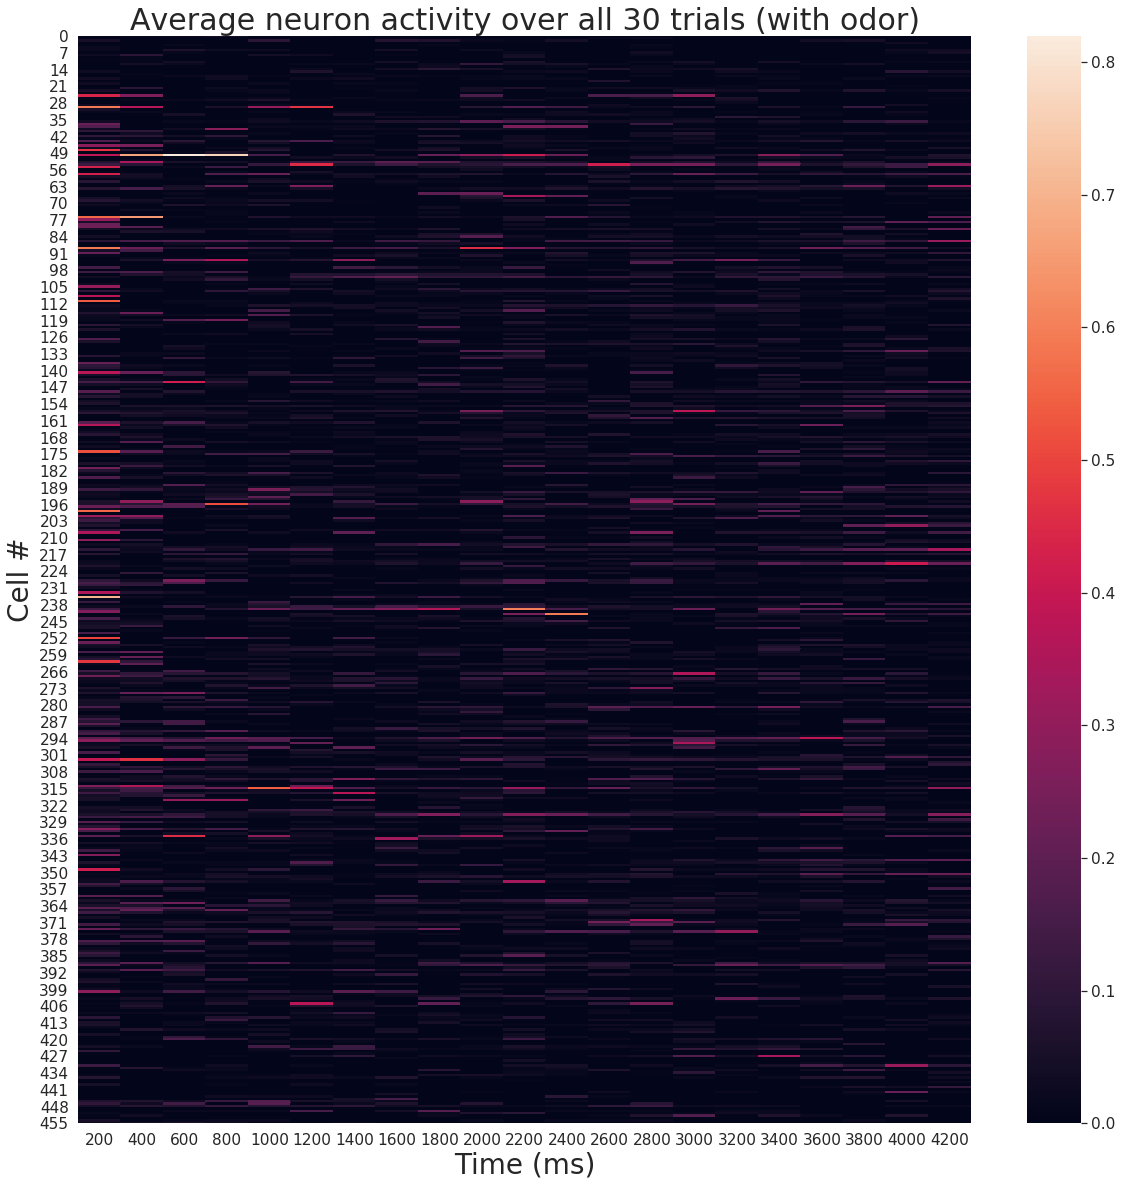

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import os 
#os.mkdir("./plots")
print("binned dic")

c=0
data_dic = {}
spikes = {}
for trial,bin in binned_dic.items():
    #print("trial:", trial)
    times,cells = [],[]
    for time,activities in bin.items():
        #print("time:", time)
        for cell,v in activities.items():
            if cell<=12:  # to skip over behavior and metadata
                continue
            activity_sum = 0
            count = 0
            for x in v:
                activity_sum += x
                count += 1
            mean_activity = activity_sum / count
            #print("time:", time, "cell:", cell, "mean_act:", mean_activity)
            if c == 0:
                times.append(time)
                cells.append(cell-13)
            if (time,cell) not in spikes:
                spikes[(time,cell)] = []
                spikes[(time,cell)].append(mean_activity)
            else:
                spikes[(time,cell)].append(mean_activity)

data_dic["times"] = times
data_dic["cells"] = cells

spikes_list = []
for k,v in spikes.items():
    spikes_list.append(sum(v) / len(v))

data_dic["spikes"] = spikes_list


df = pd.DataFrame.from_dict(data_dic)
df = df.pivot(index='cells', columns='times', values='spikes')
fig, ax = plt.subplots(figsize=(20,20)) 
#sns.set(font_scale=1.4)
b = sns.heatmap(df, annot=False)
b.axes.set_title("Average neuron activity over all 30 trials (with odor)",fontsize=30)
b.set_xlabel("Time (ms)",fontsize=28)
b.set_ylabel("Cell #",fontsize=28)
plt.savefig("plots/avrg_activity_day4.png")

binned dic
times  200   400       600   800   1000  1200  1400  1600      1800      2000  \
cells                                                                           
13      0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000   
14      0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000   
15      0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  0.406975  0.720175   
16      0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000   
17      0.0   0.0  0.525425   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000   

times  ...  2400      2600  2800  3000  3200  3400  3600  3800    4000  4200  
cells  ...                                                                    
13     ...   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  0.0000   0.0  
14     ...   0.0  0.409825   0.0   0.0   0.0   0.0   0.0   0.0  0.0000   0.0  
15     ...   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  0.0000   0.0  
16     ...   0.0  0.000000

times  200   400   600   800   1000  1200  1400      1600  1800  2000  ...  \
cells                                                                  ...   
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  ...   
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  ...   
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.954875   0.0   0.0  ...   
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  ...   
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  ...   

times  2400  2600  2800  3000  3200  3400  3600  3800  4000  4200  
cells                                                              
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
17      0.0   0.0   0.0   0.0   0.0   0.0   0

times  200   400   600   800   1000  1200  1400  1600  1800  2000  ...  2400  \
cells                                                              ...         
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

times  2600  2800  3000  3200  3400  3600  3800  4000  4200  
cells                                                        
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 r

/home/sophia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


times  200   400   600   800   1000  1200  1400  1600  1800  2000  ...  2400  \
cells                                                              ...         
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

times  2600  2800  3000  3200  3400  3600  3800  4000  4200  
cells                                                        
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 r

times  200   400   600   800   1000  1200  1400  1600    1800  2000  ...  \
cells                                                                ...   
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0000   0.0  ...   
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0000   0.0  ...   
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  1.6963   0.0  ...   
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0000   0.0  ...   
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0000   0.0  ...   

times  2400  2600  2800  3000  3200  3400  3600  3800  4000  4200  
cells                                                              
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

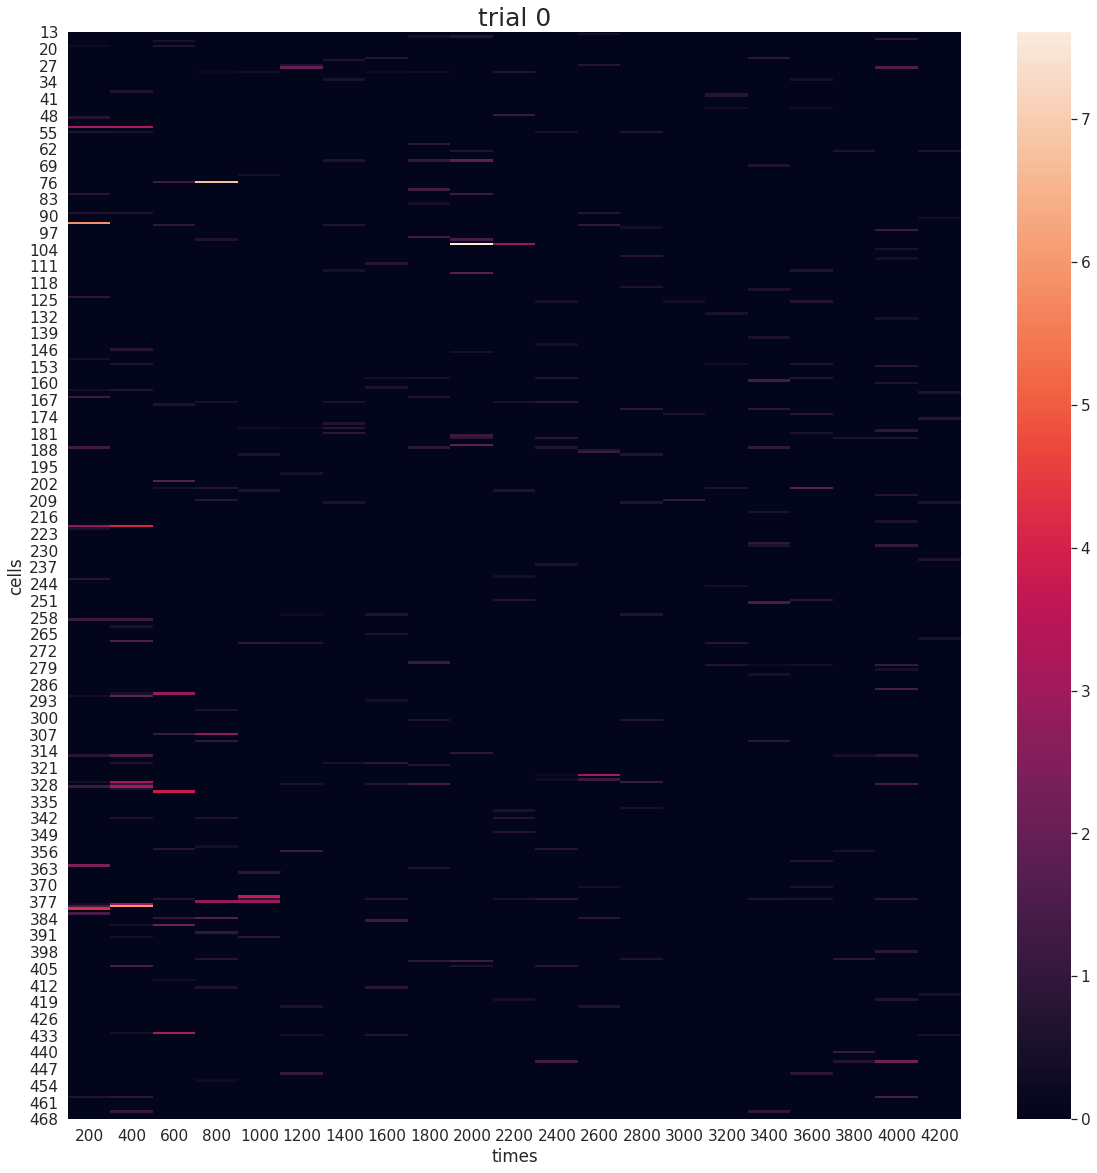

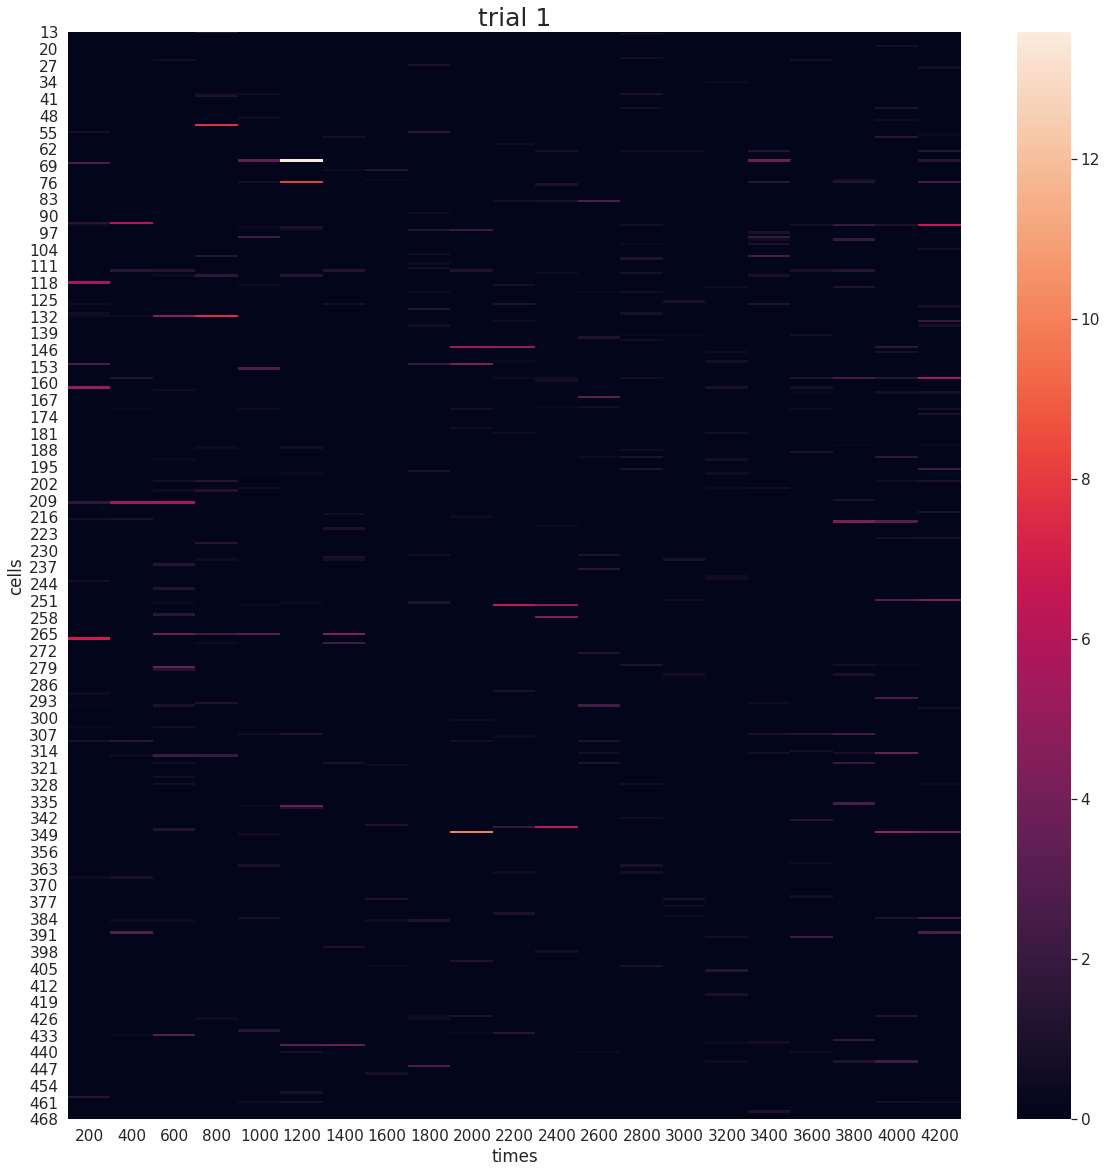

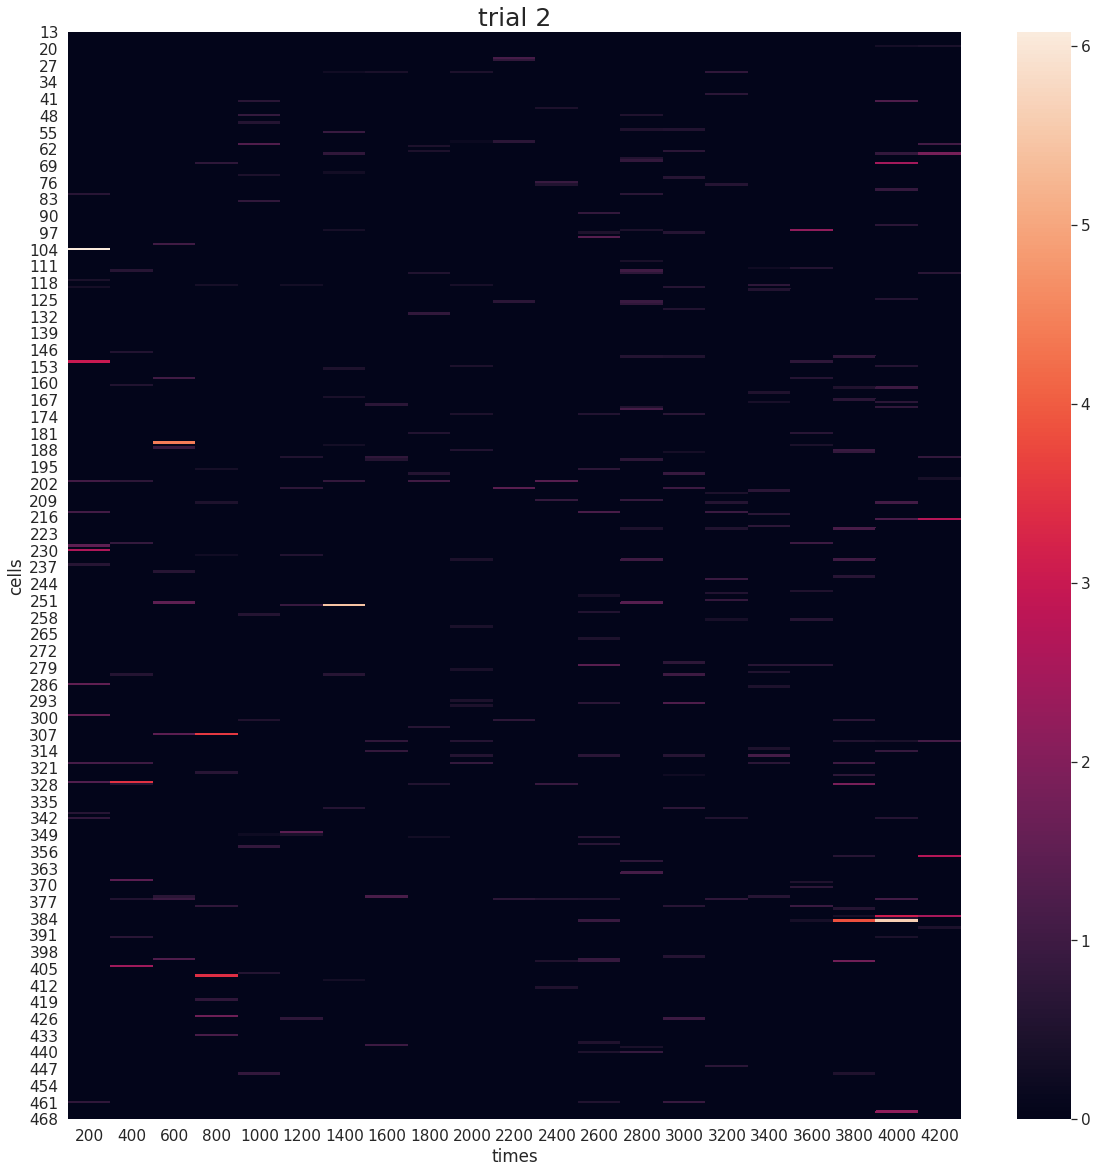

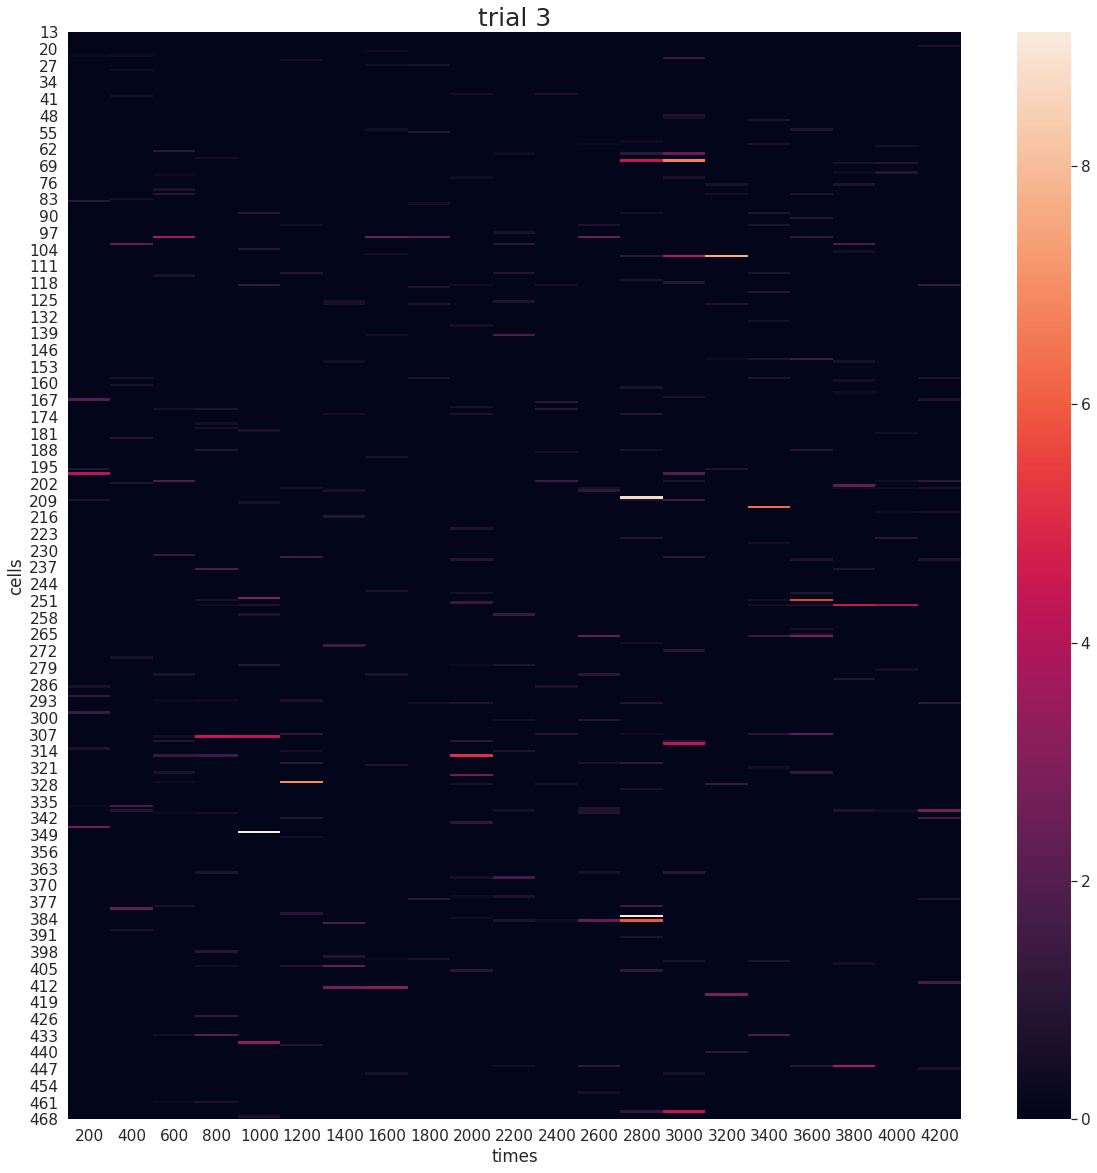

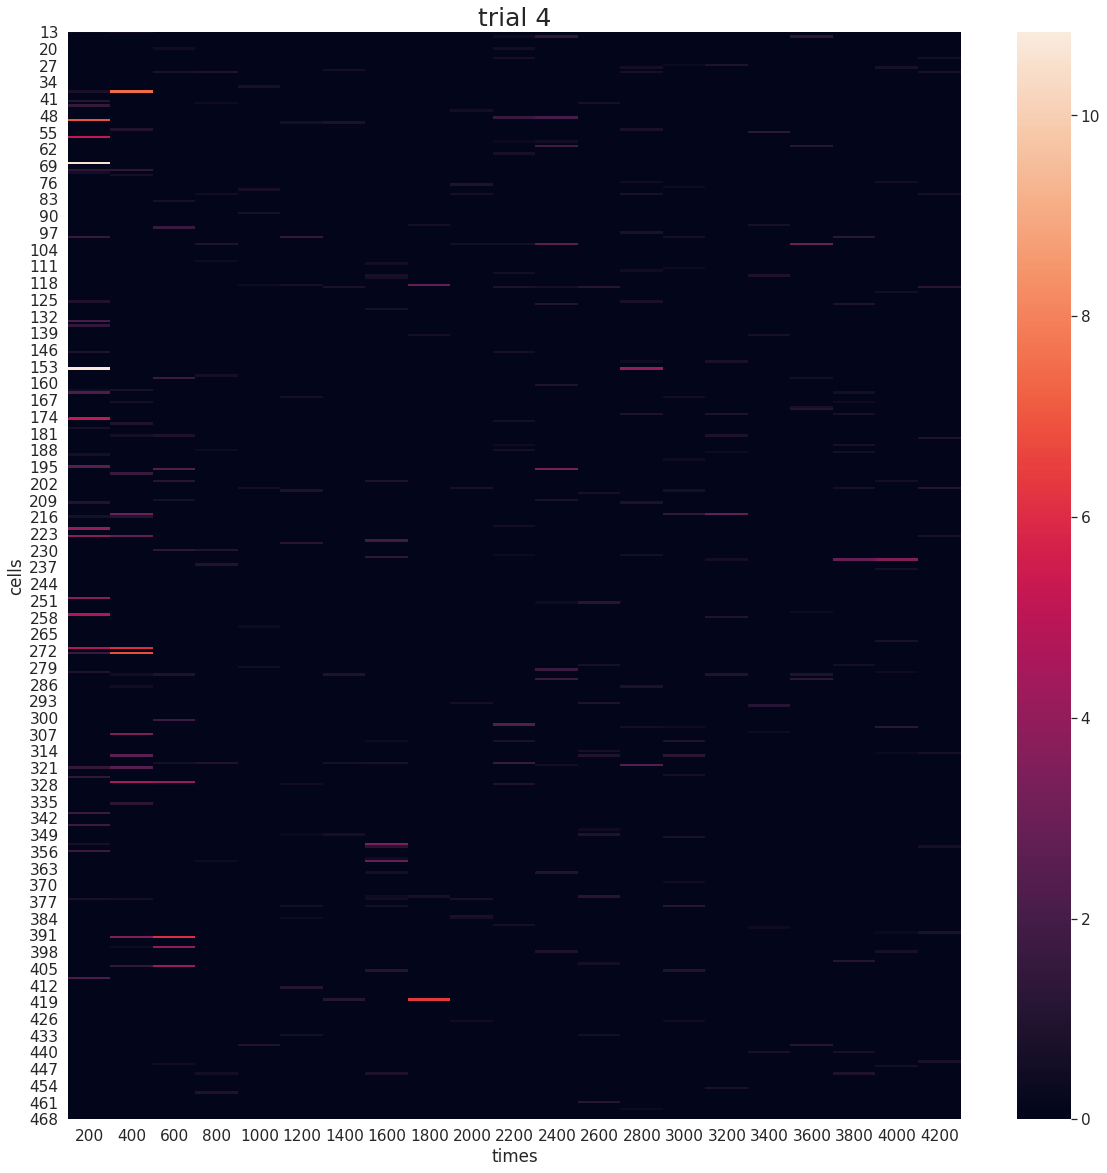

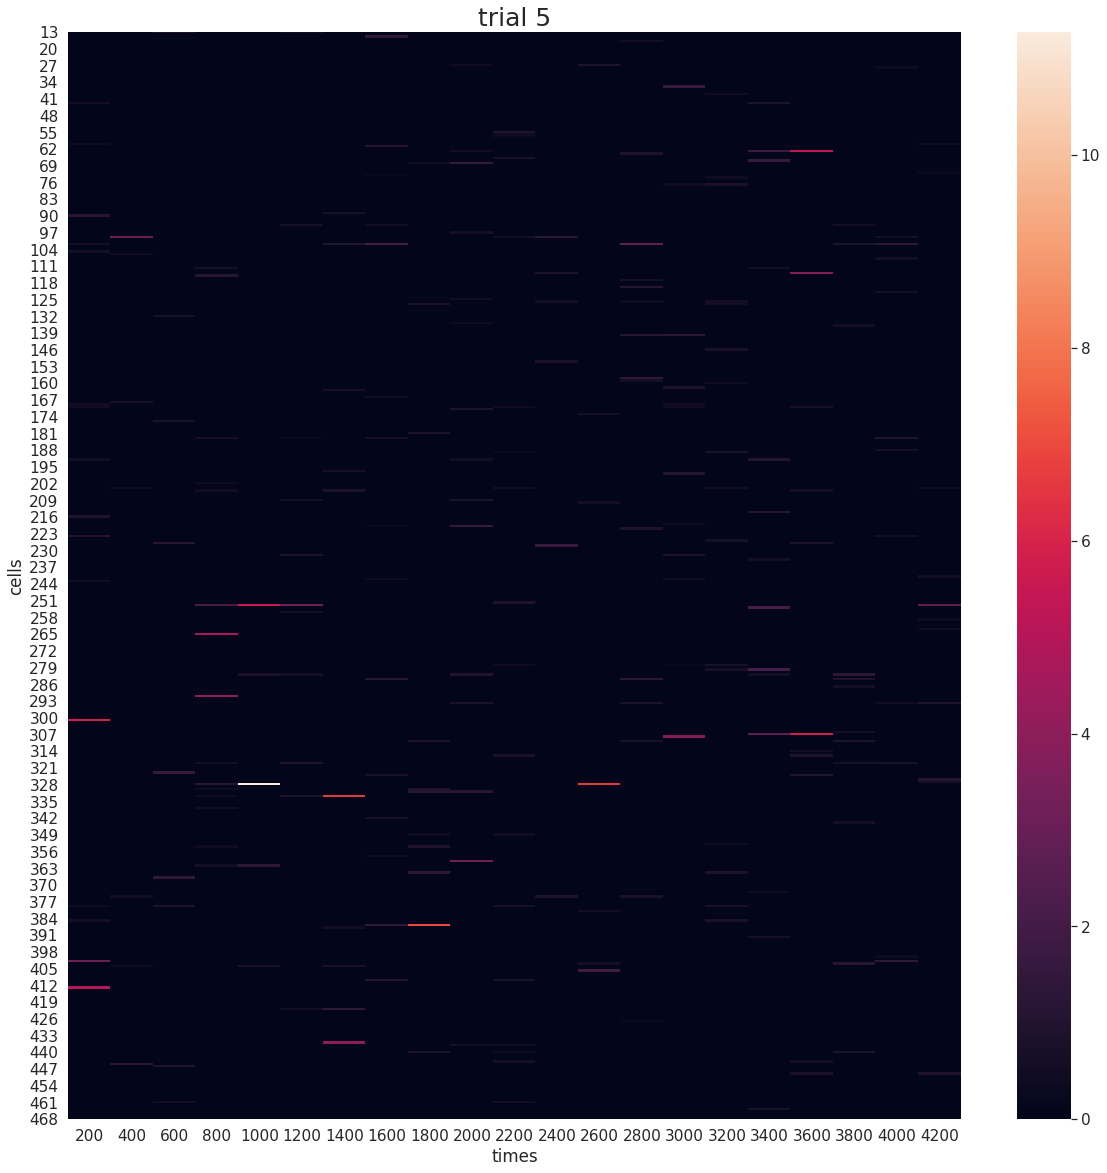

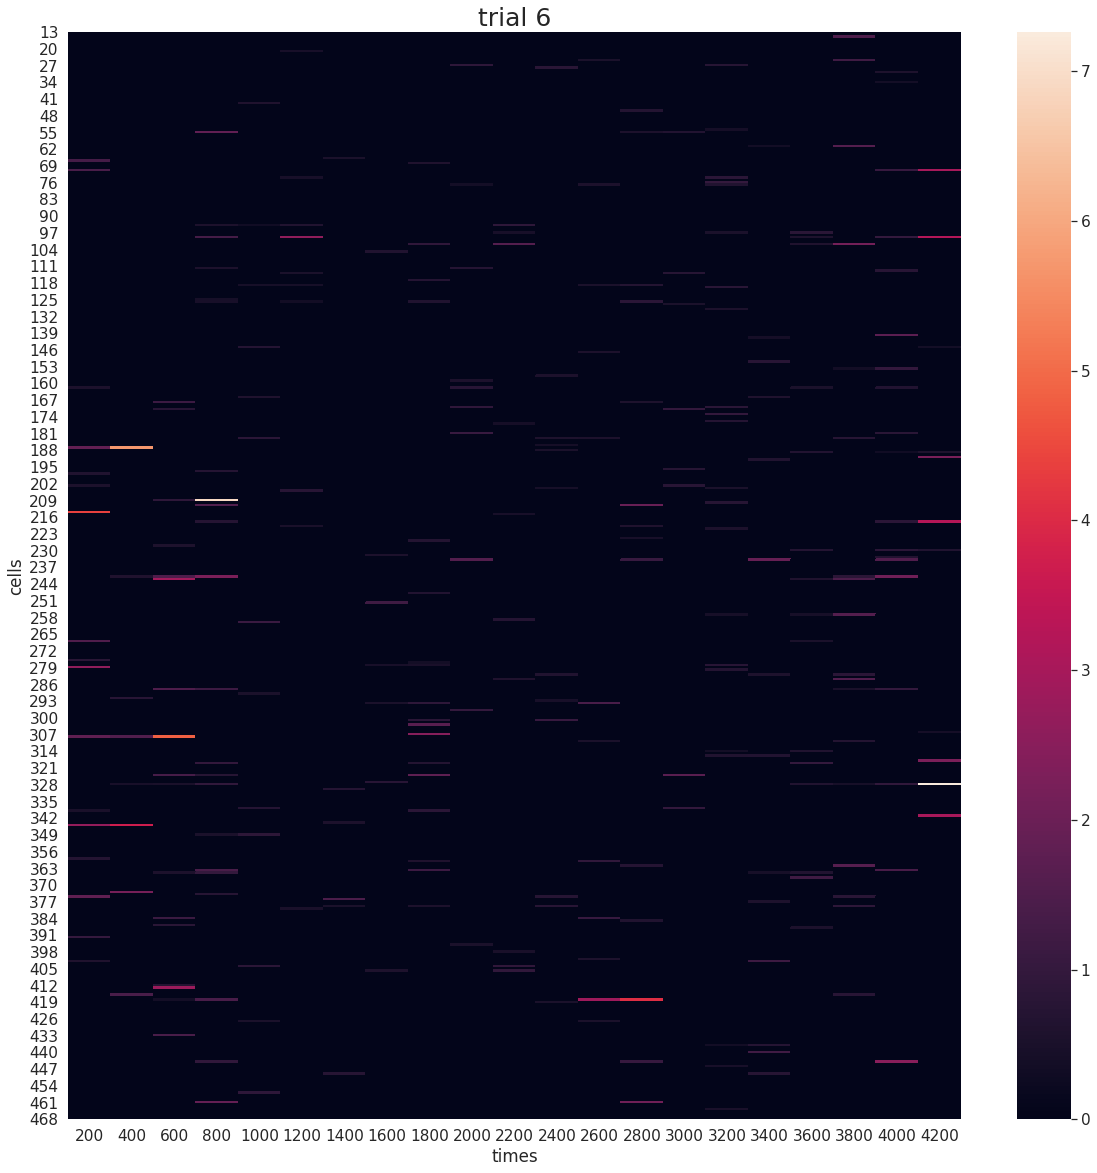

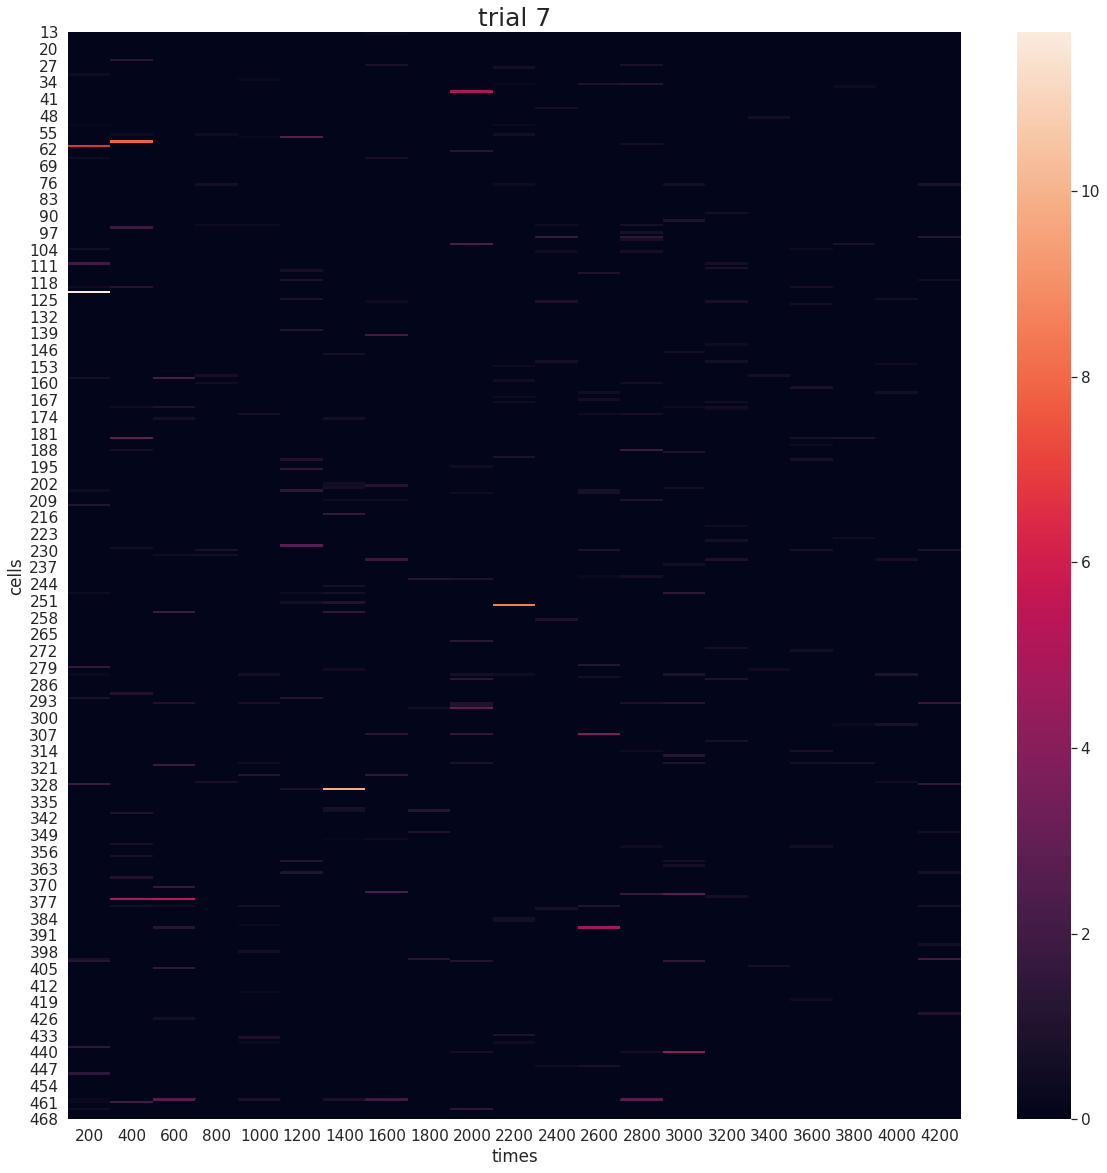

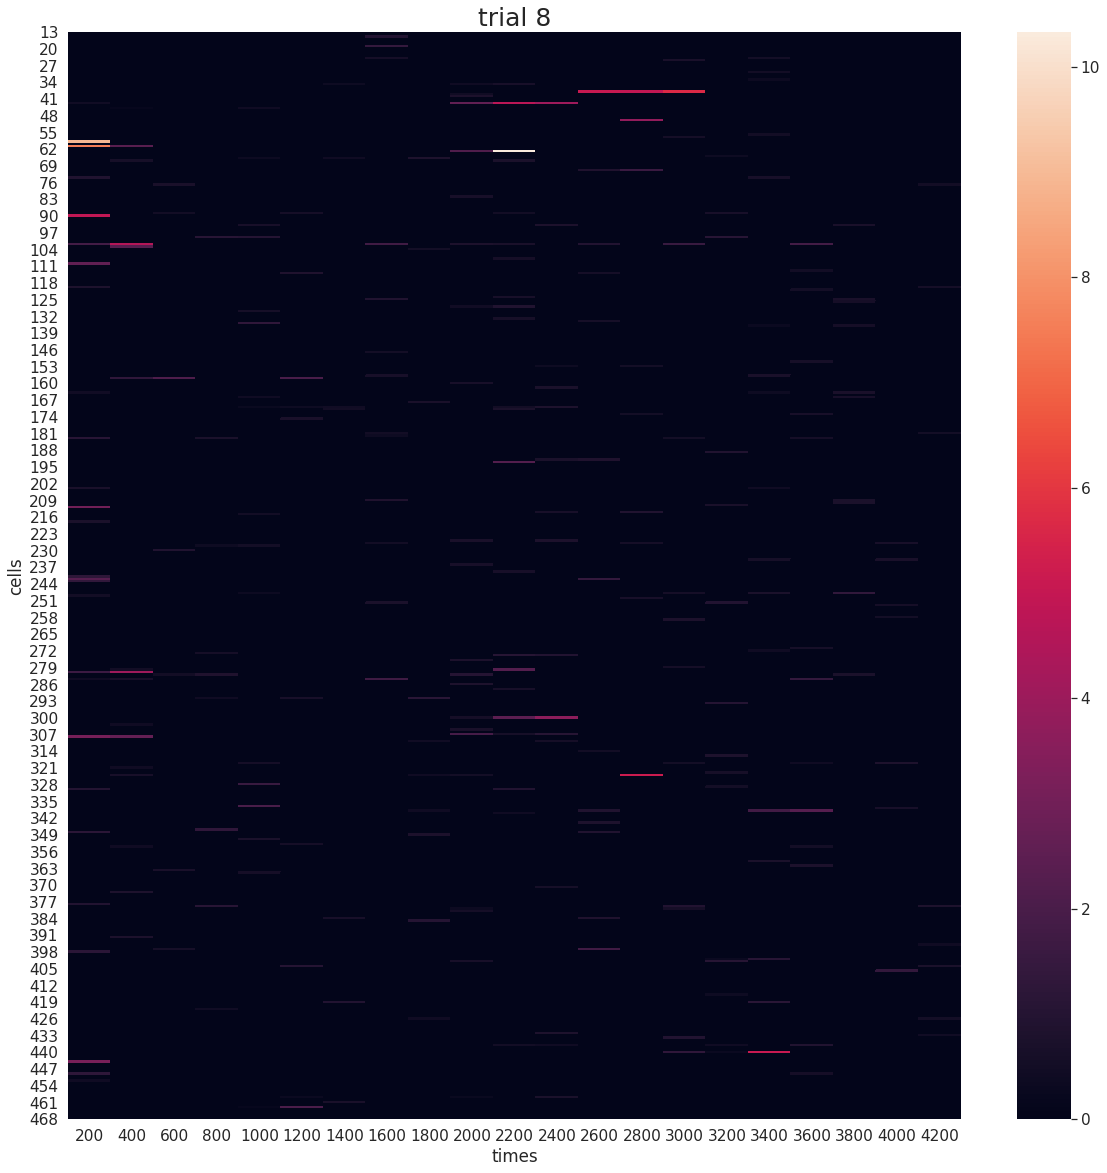

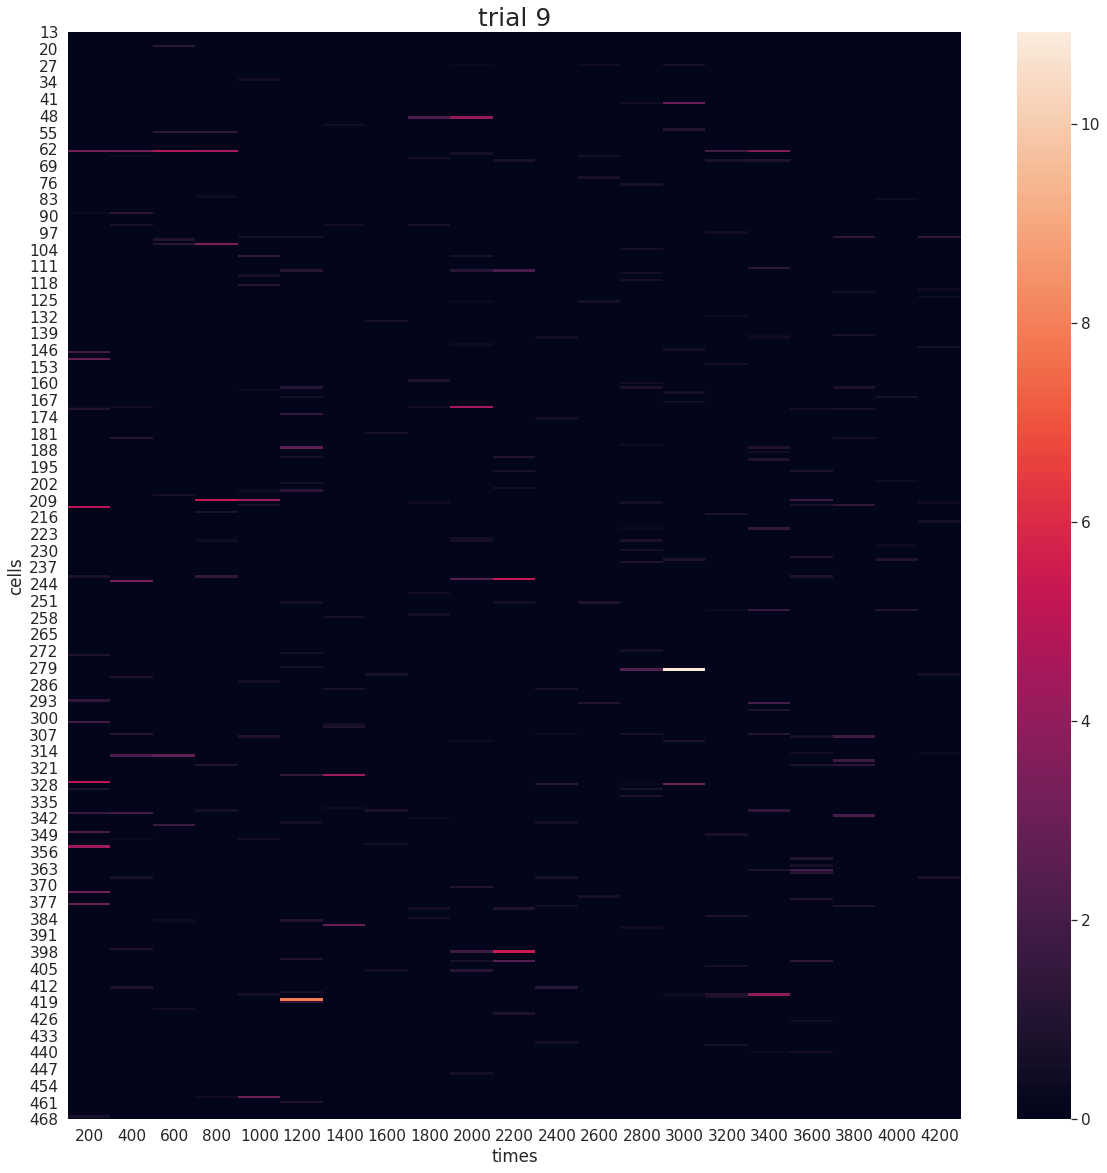

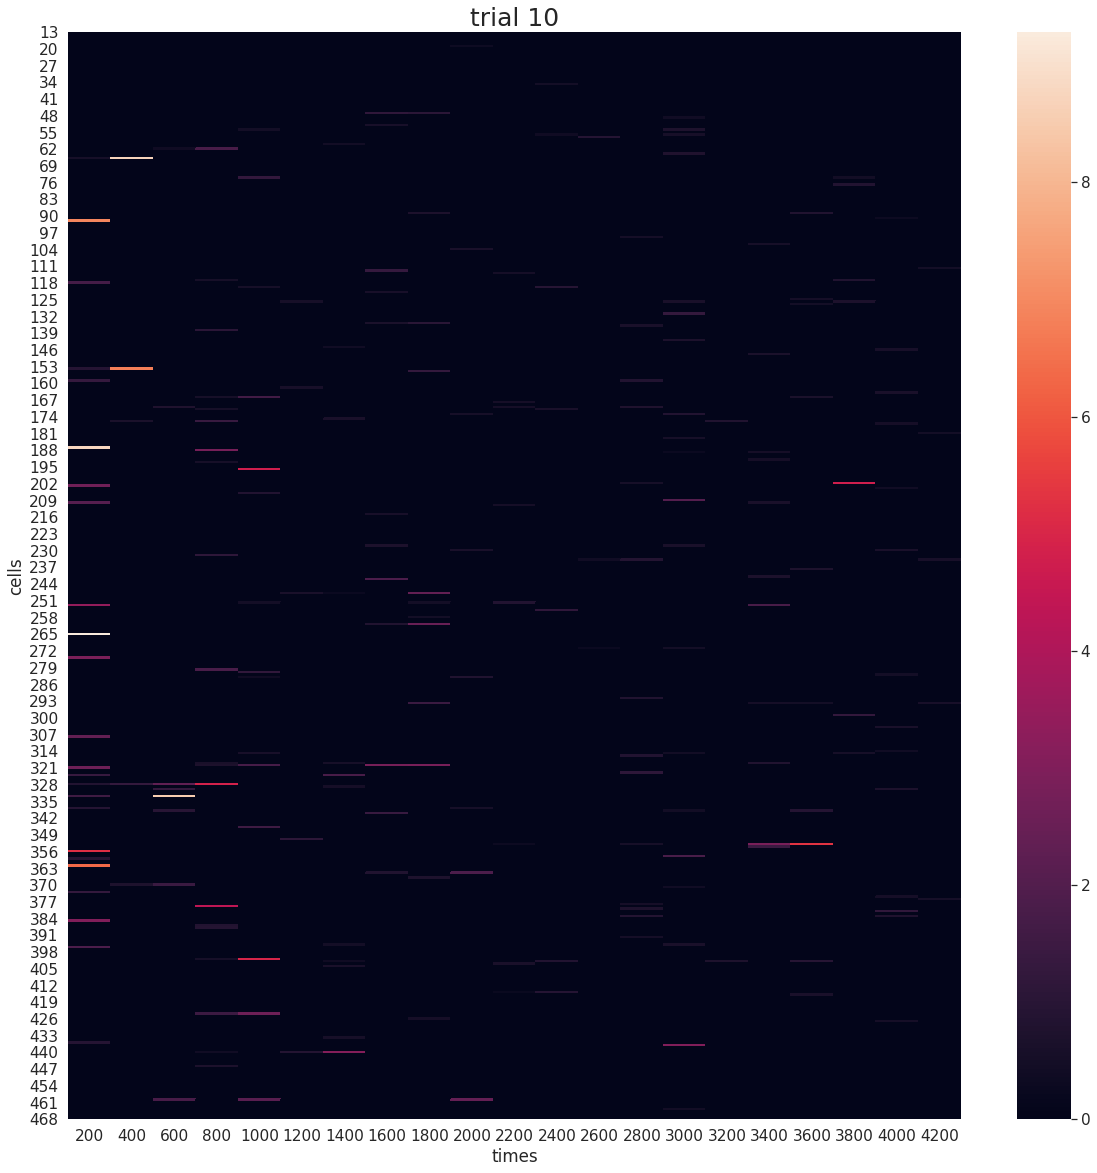

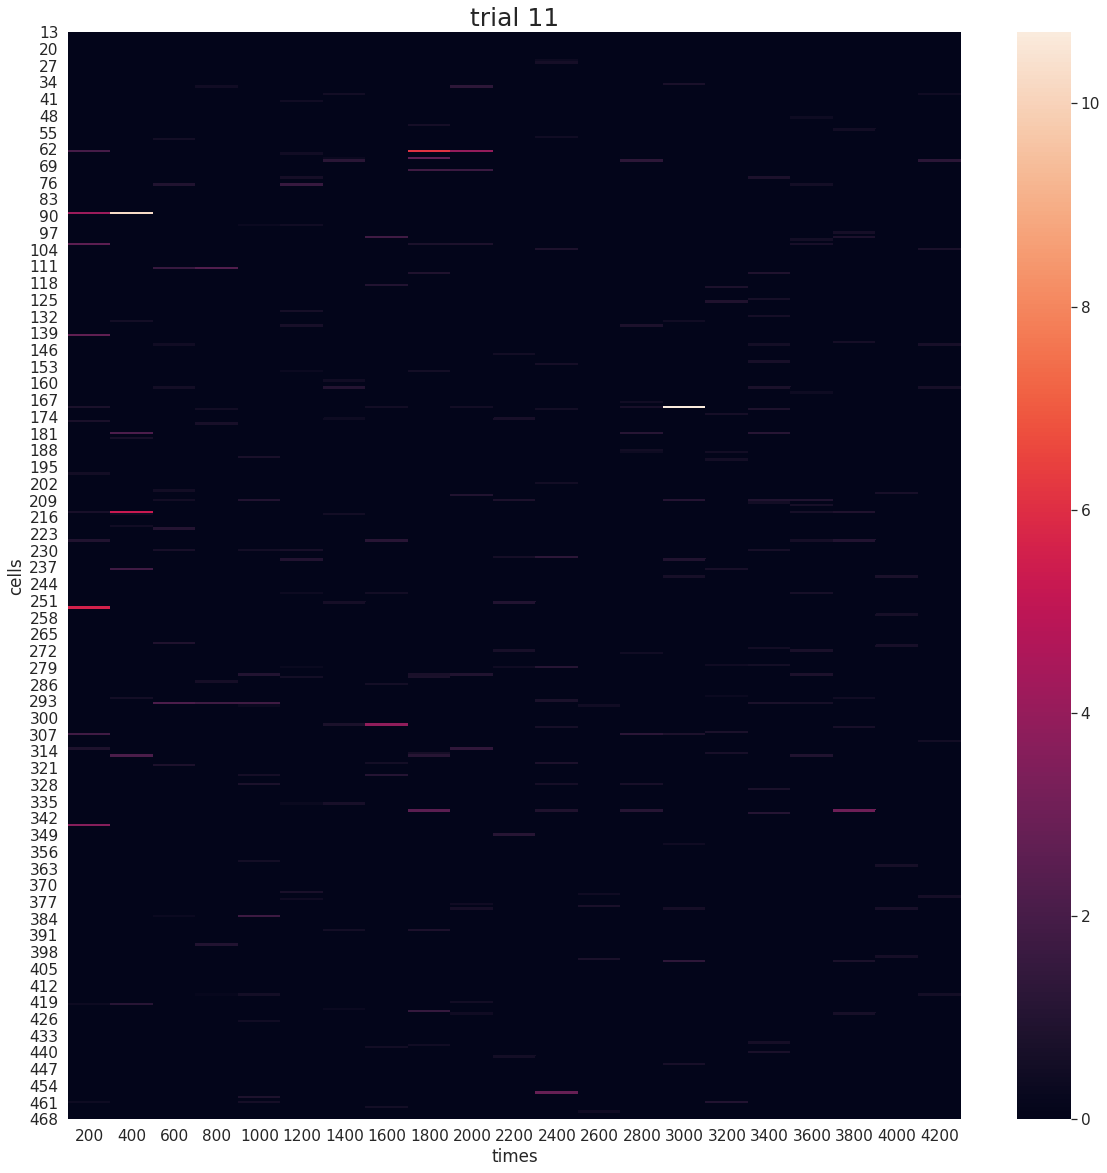

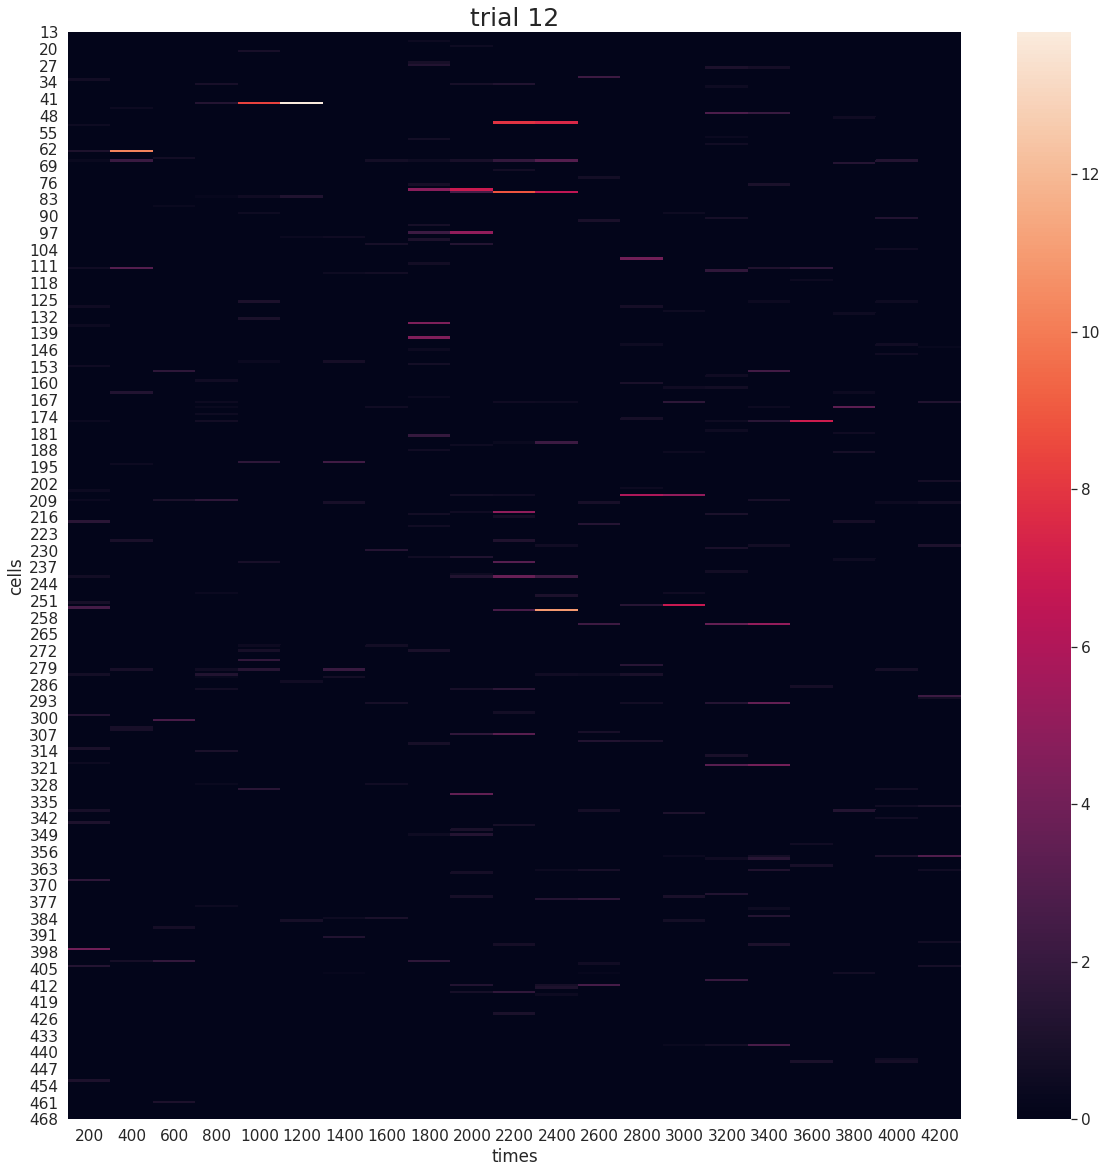

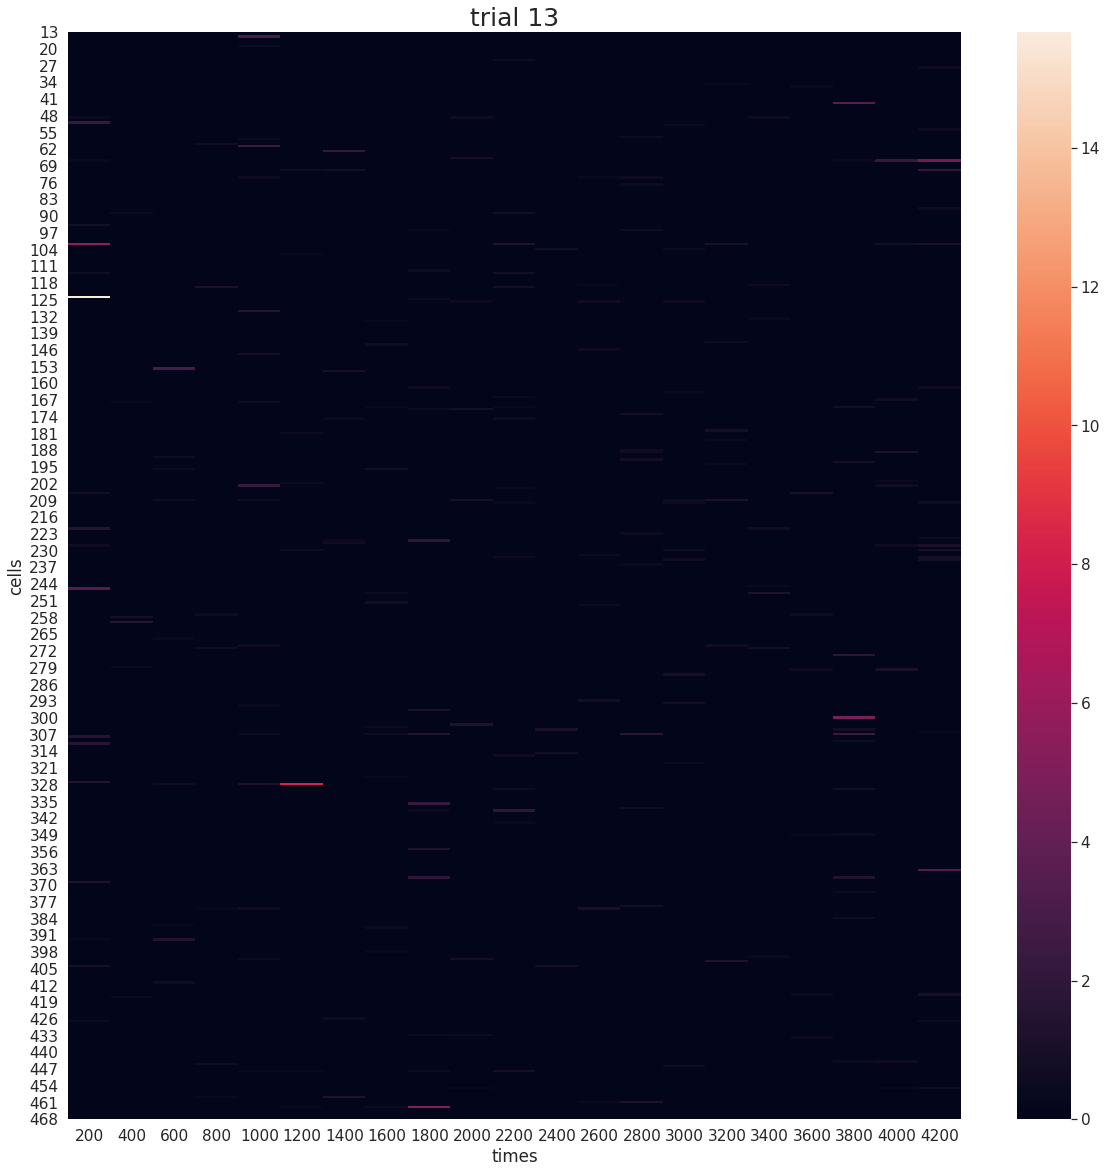

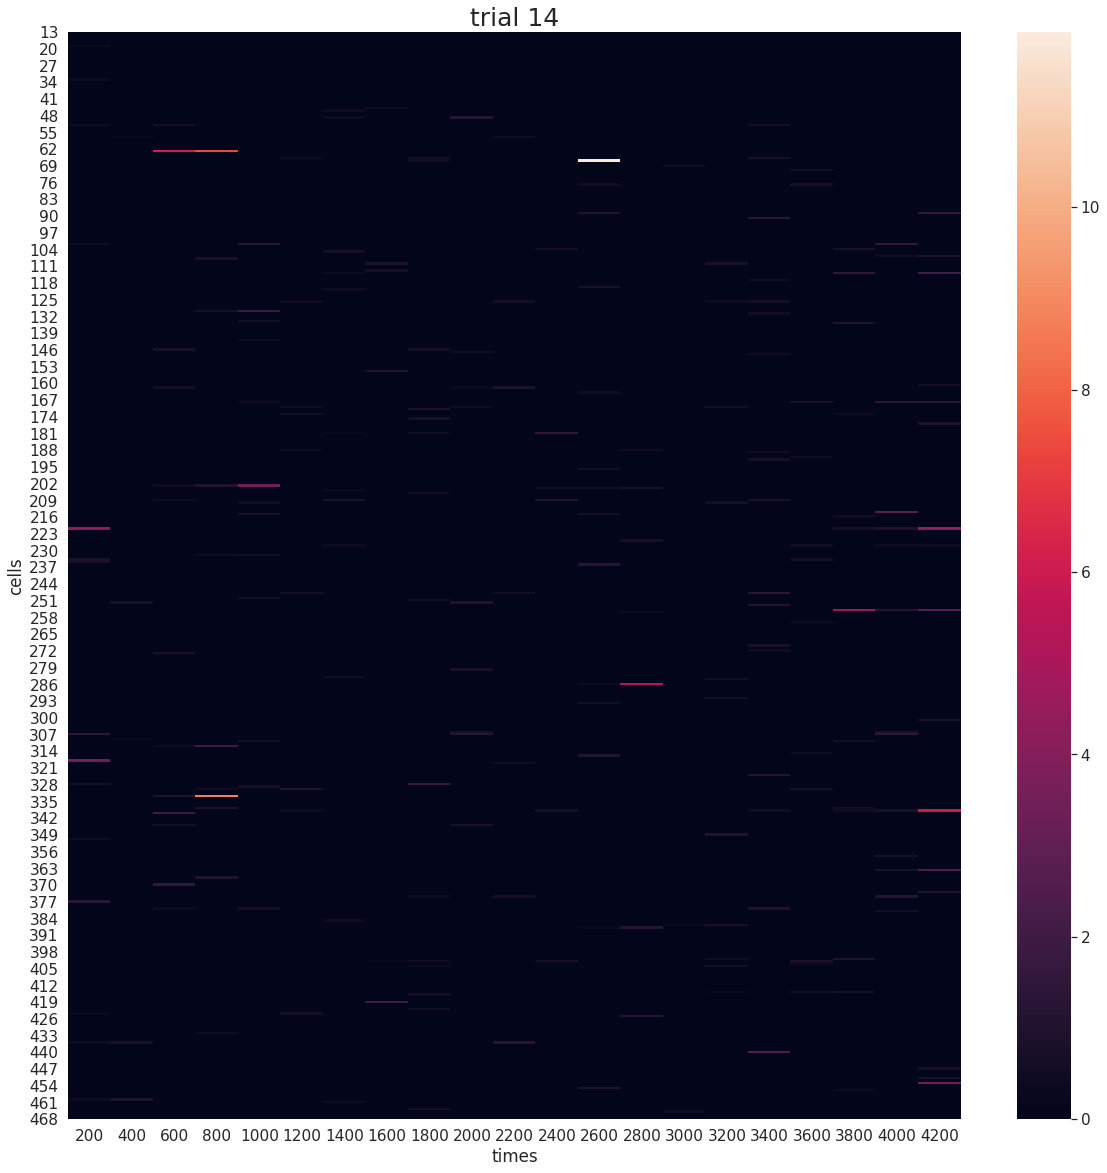

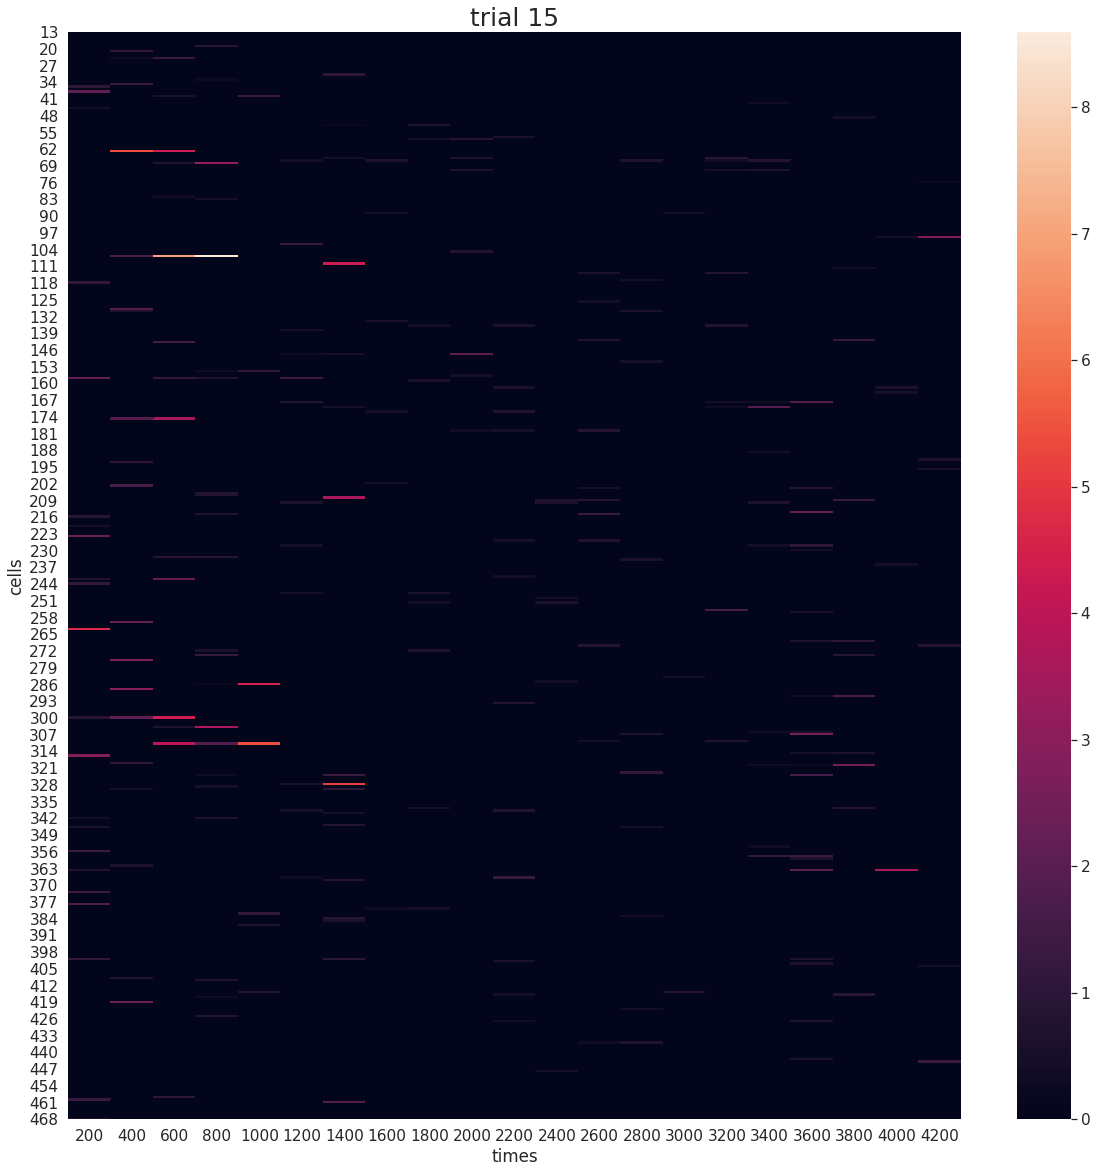

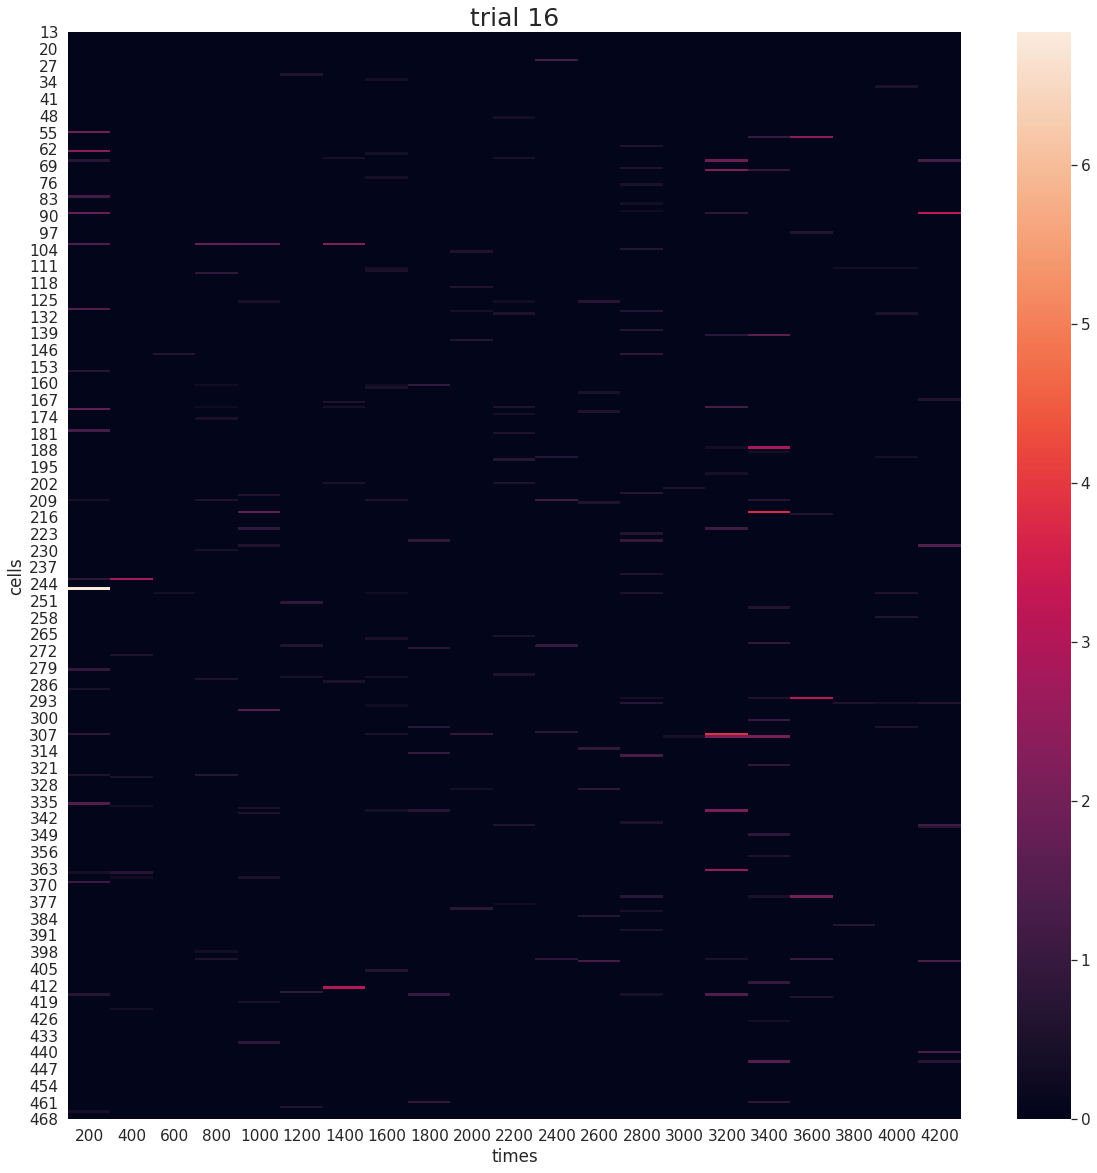

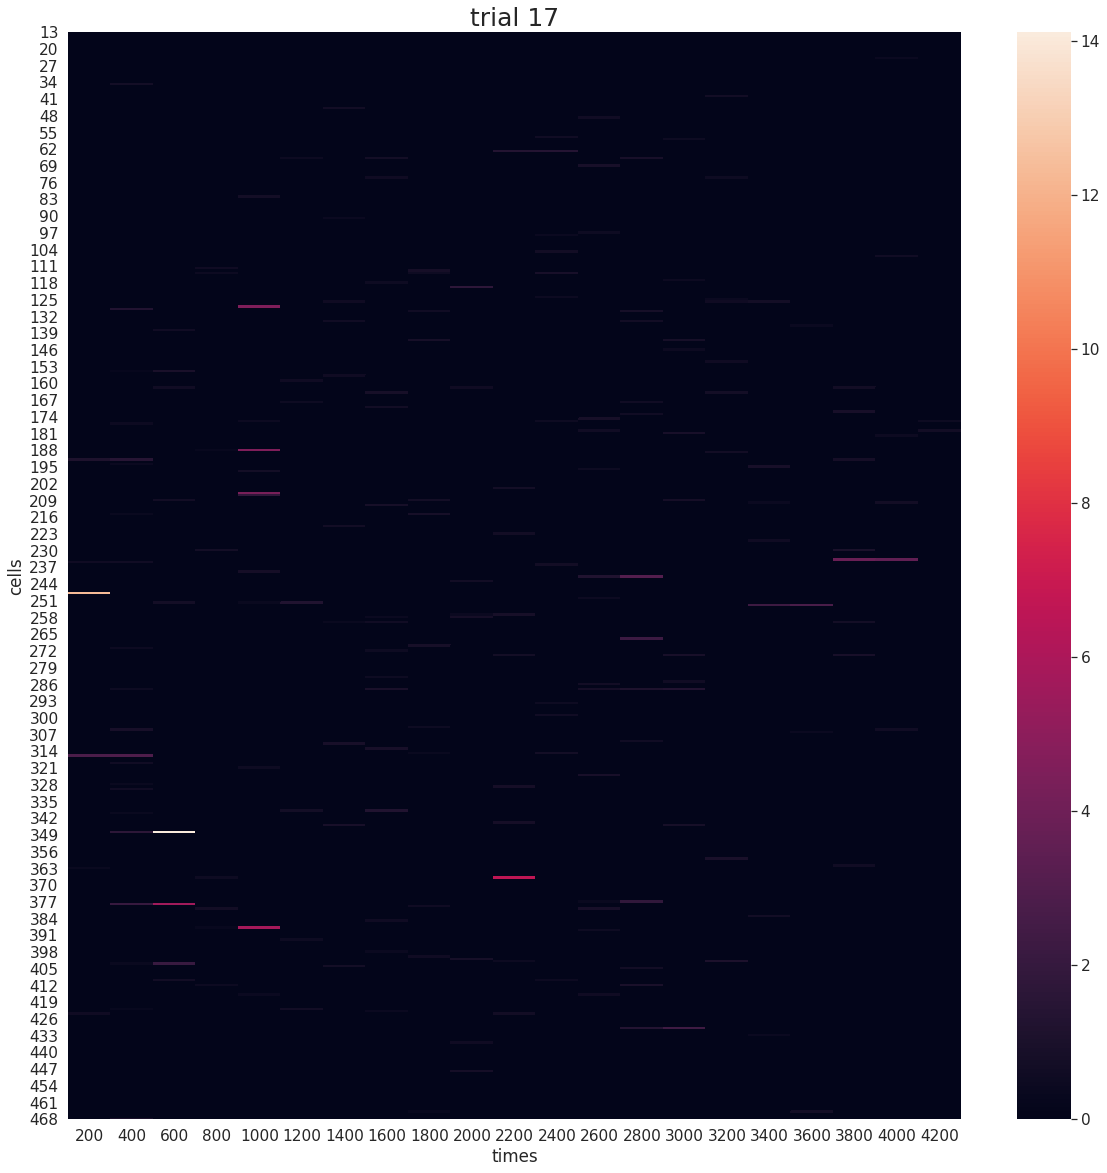

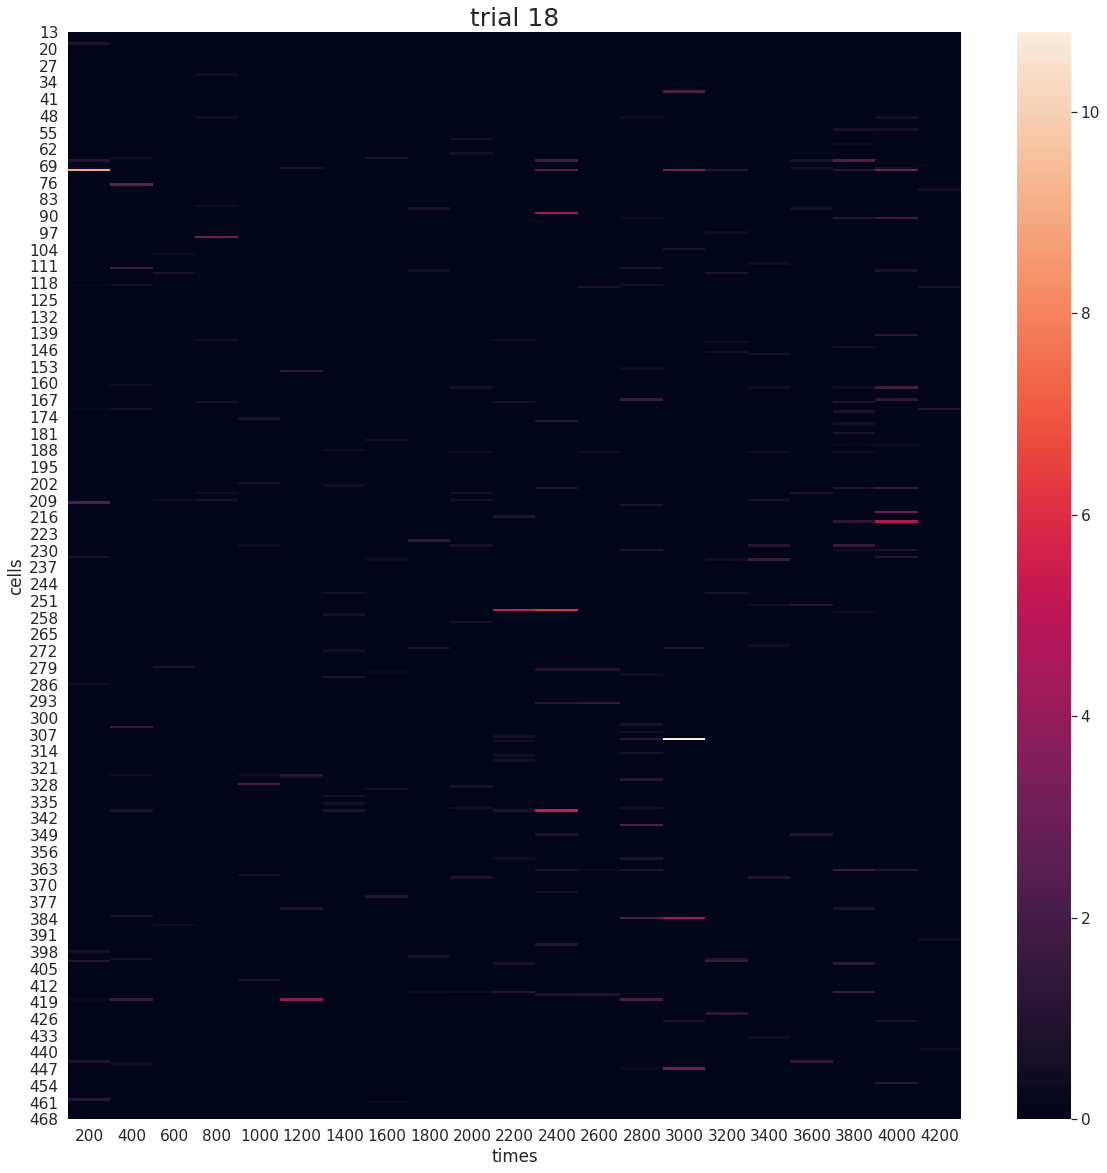

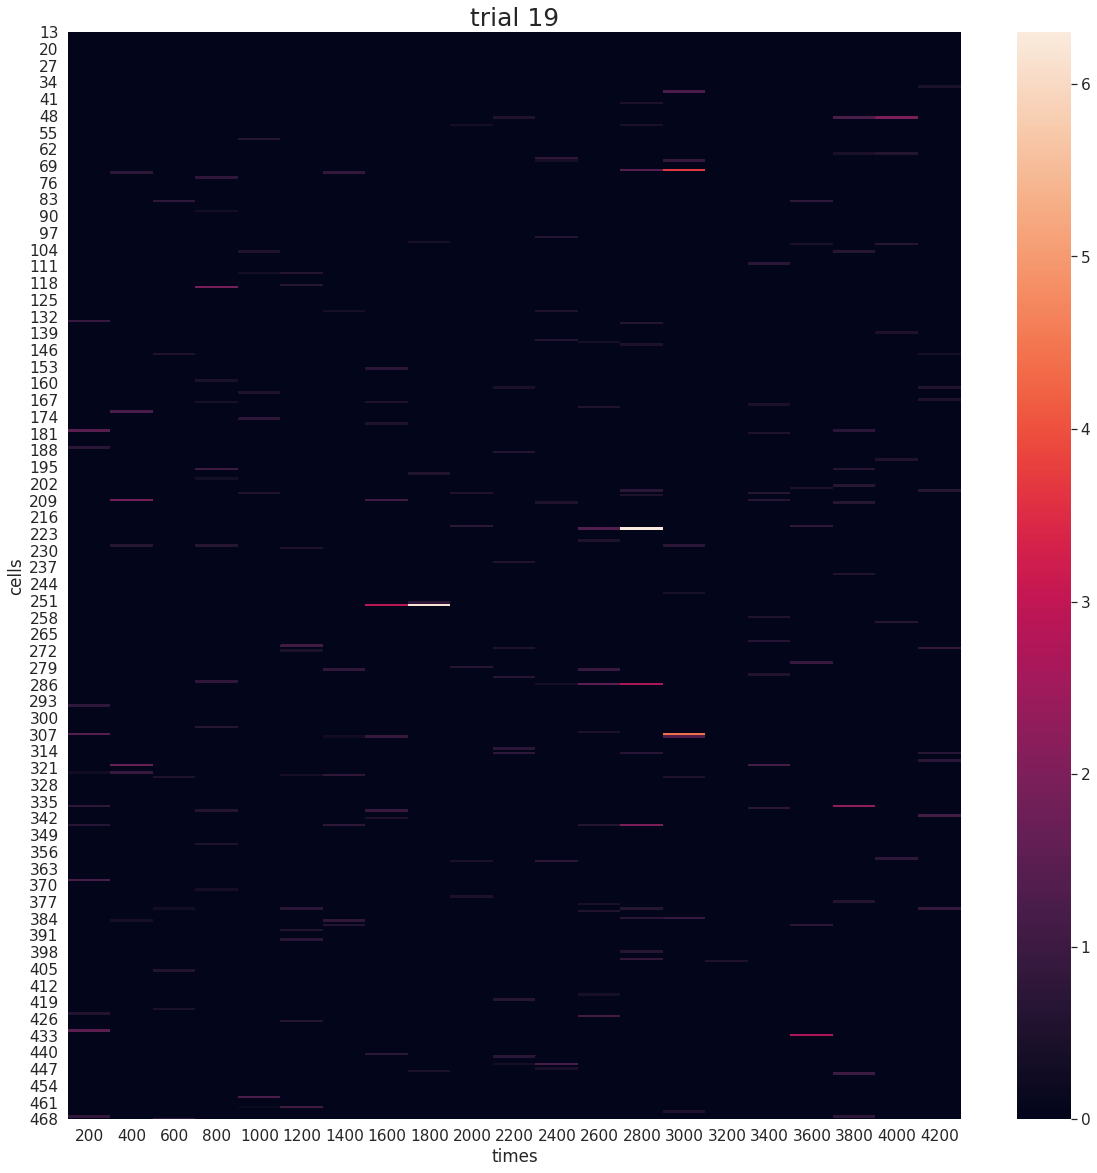

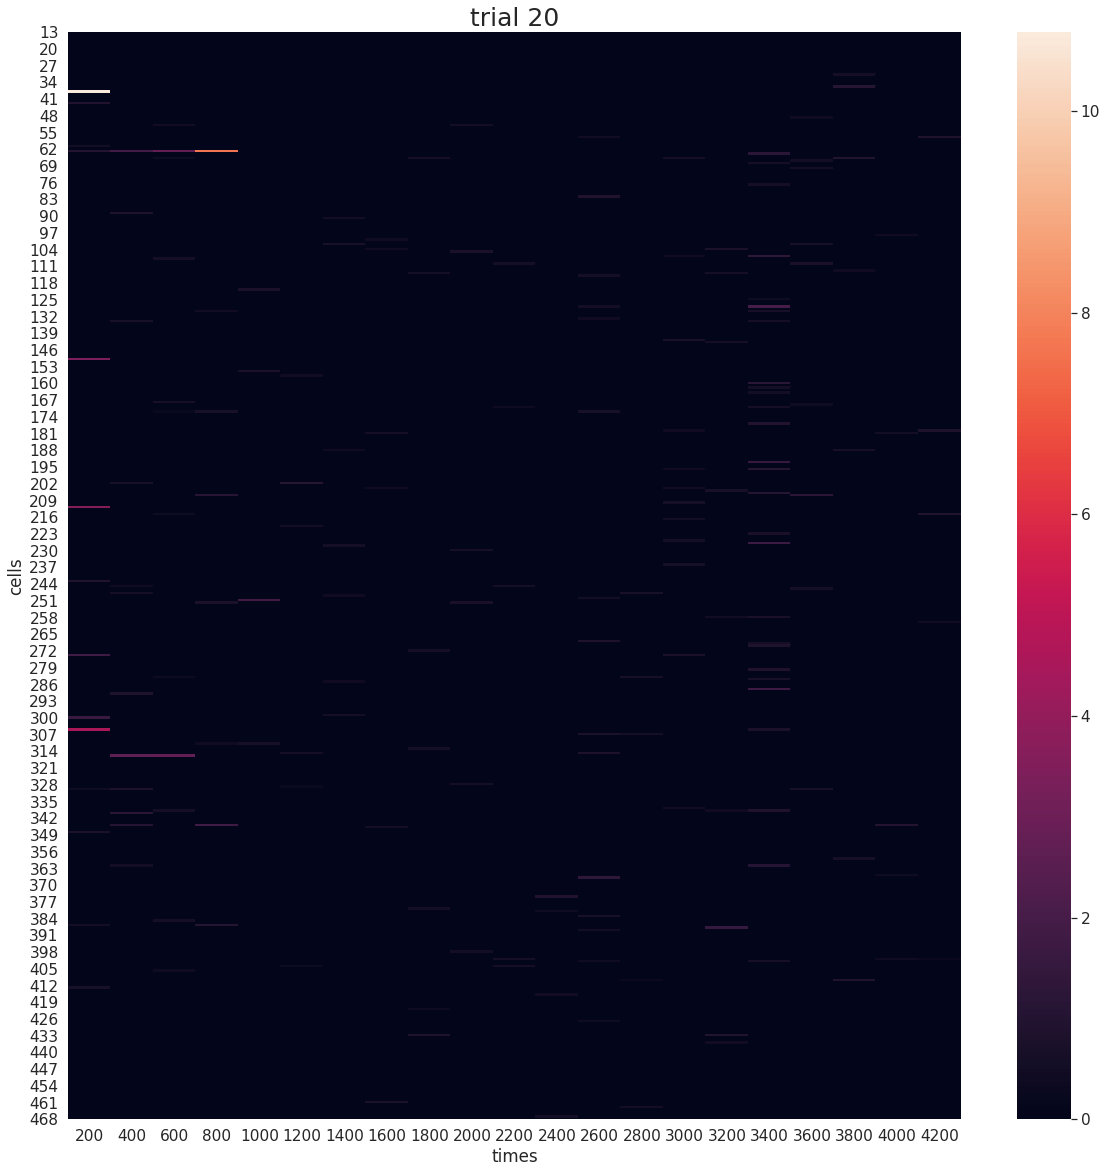

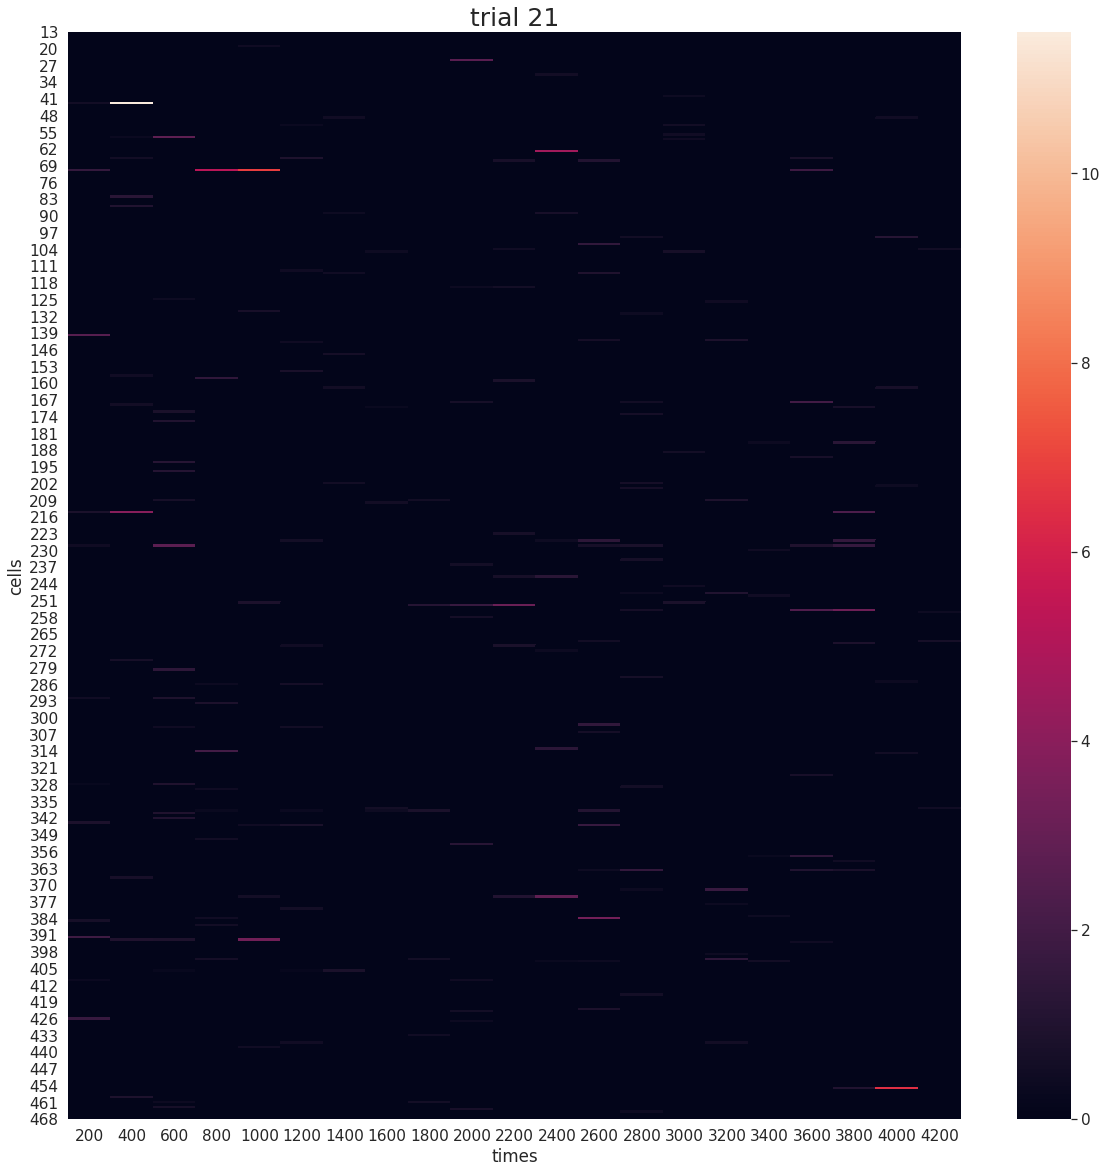

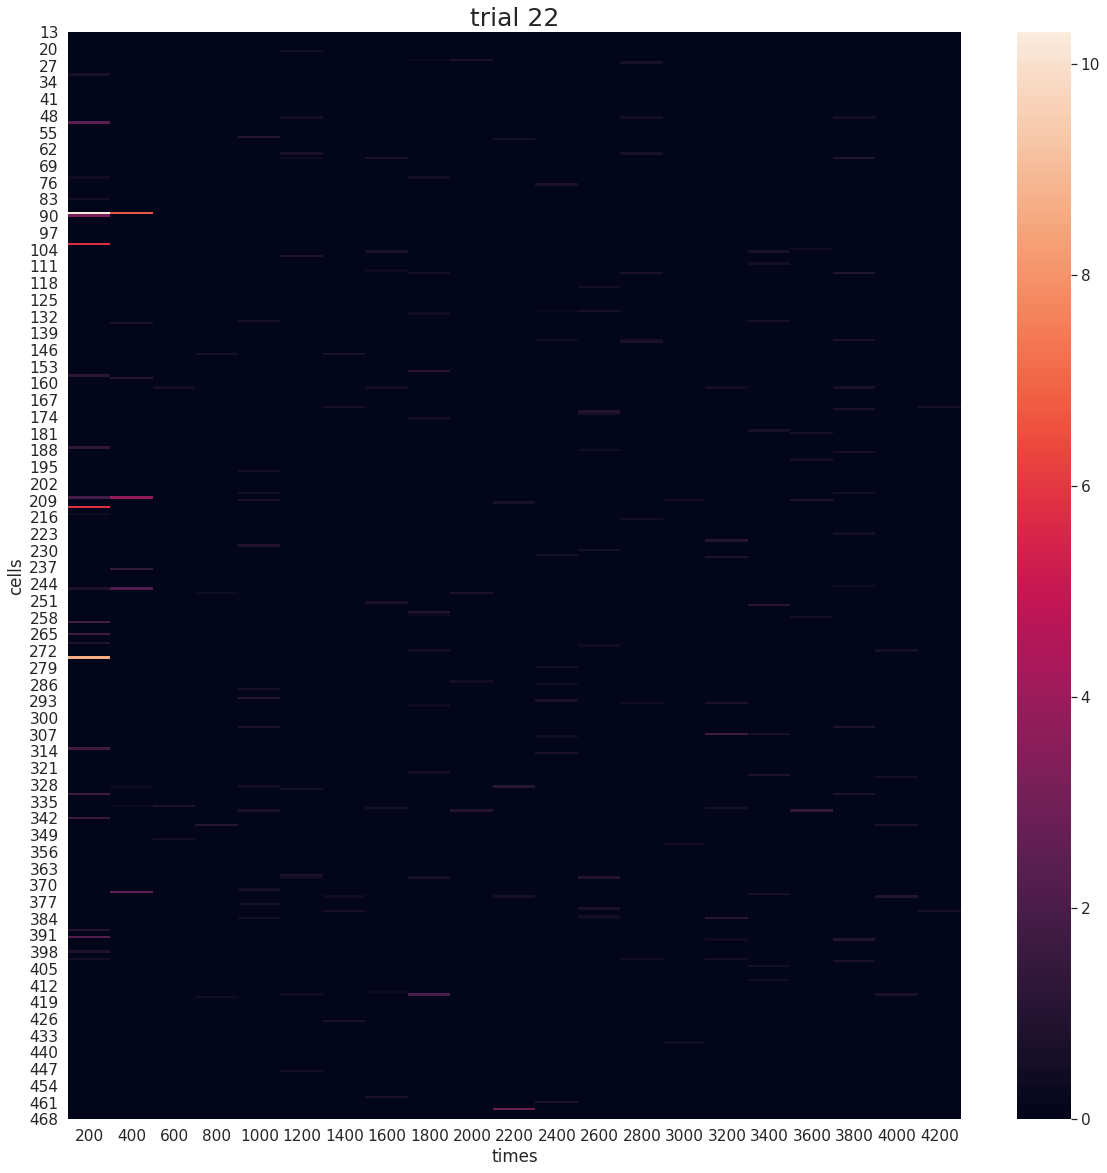

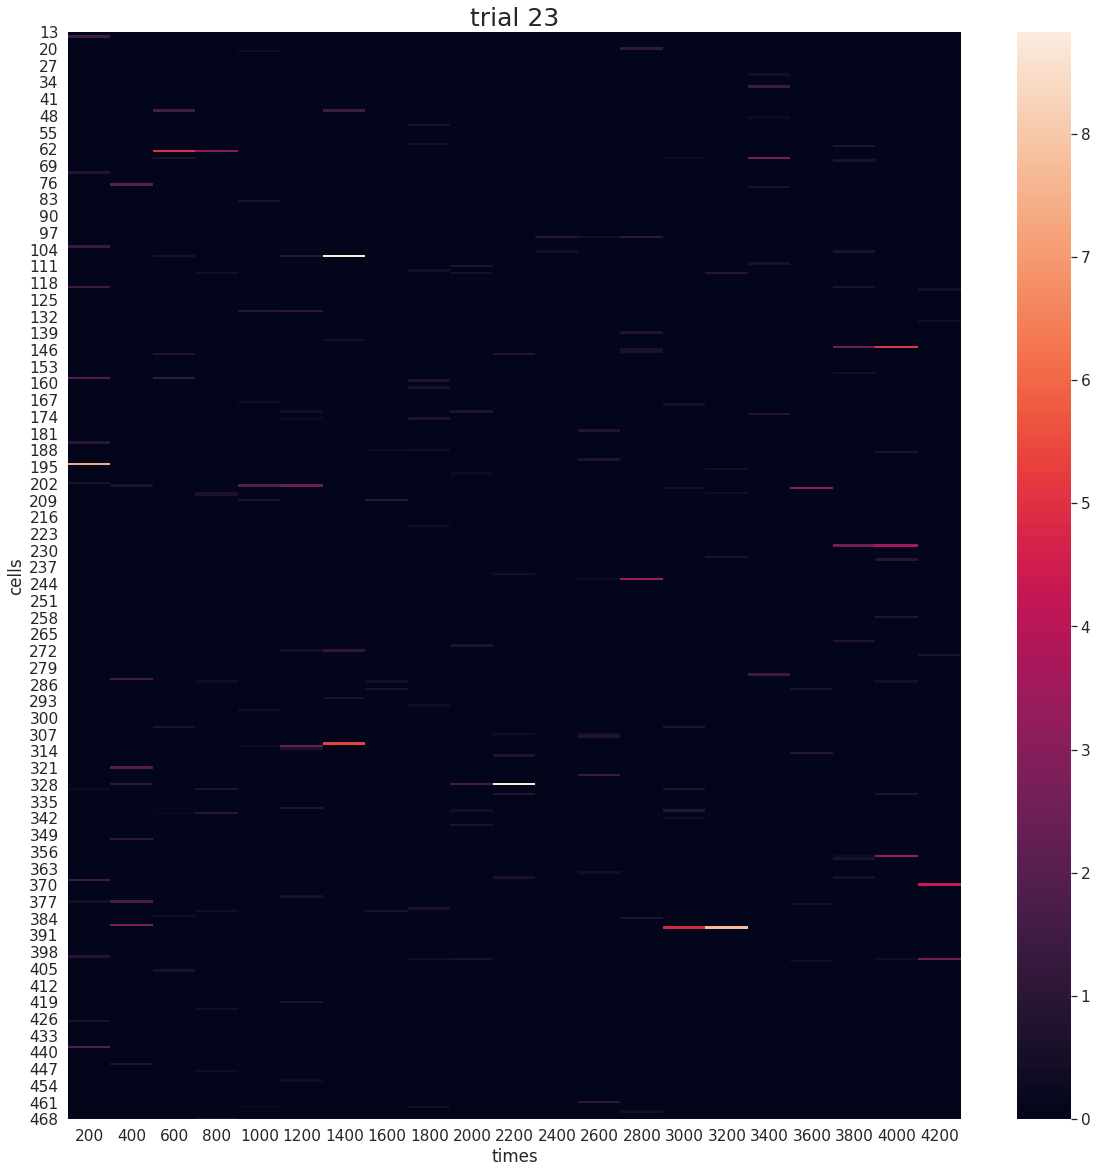

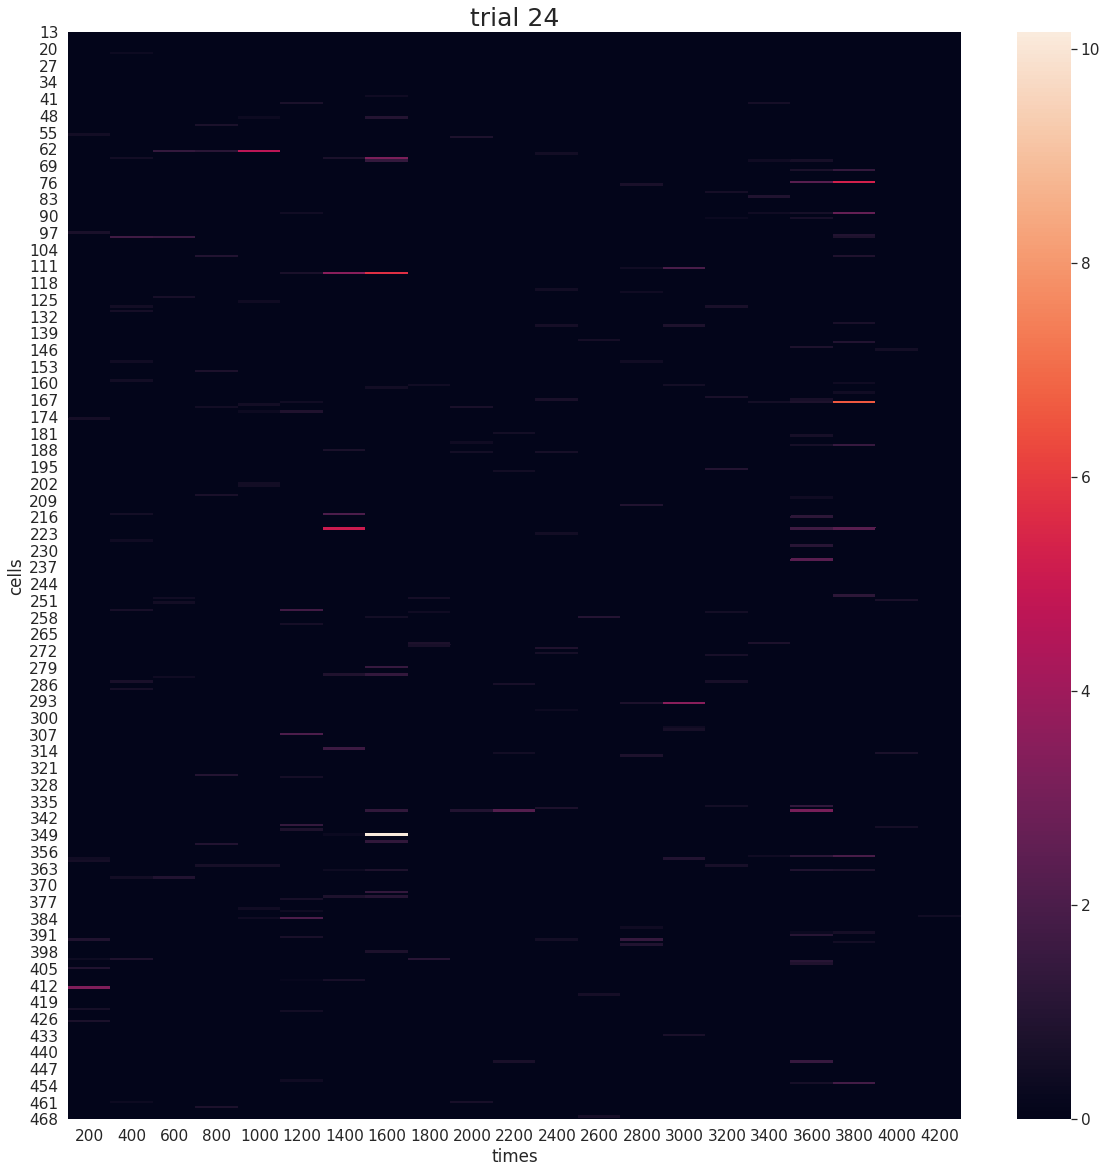

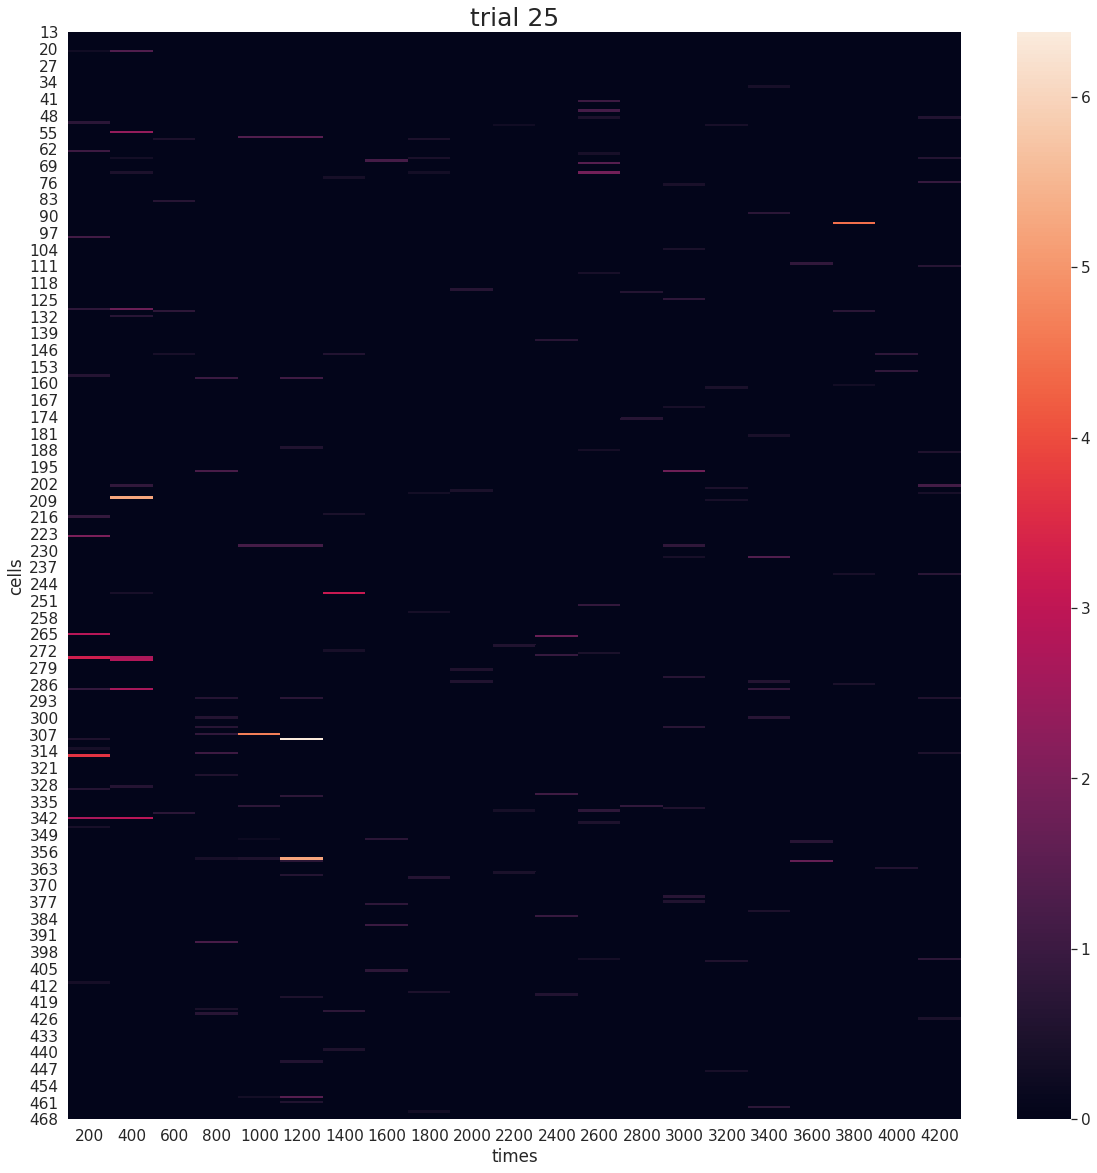

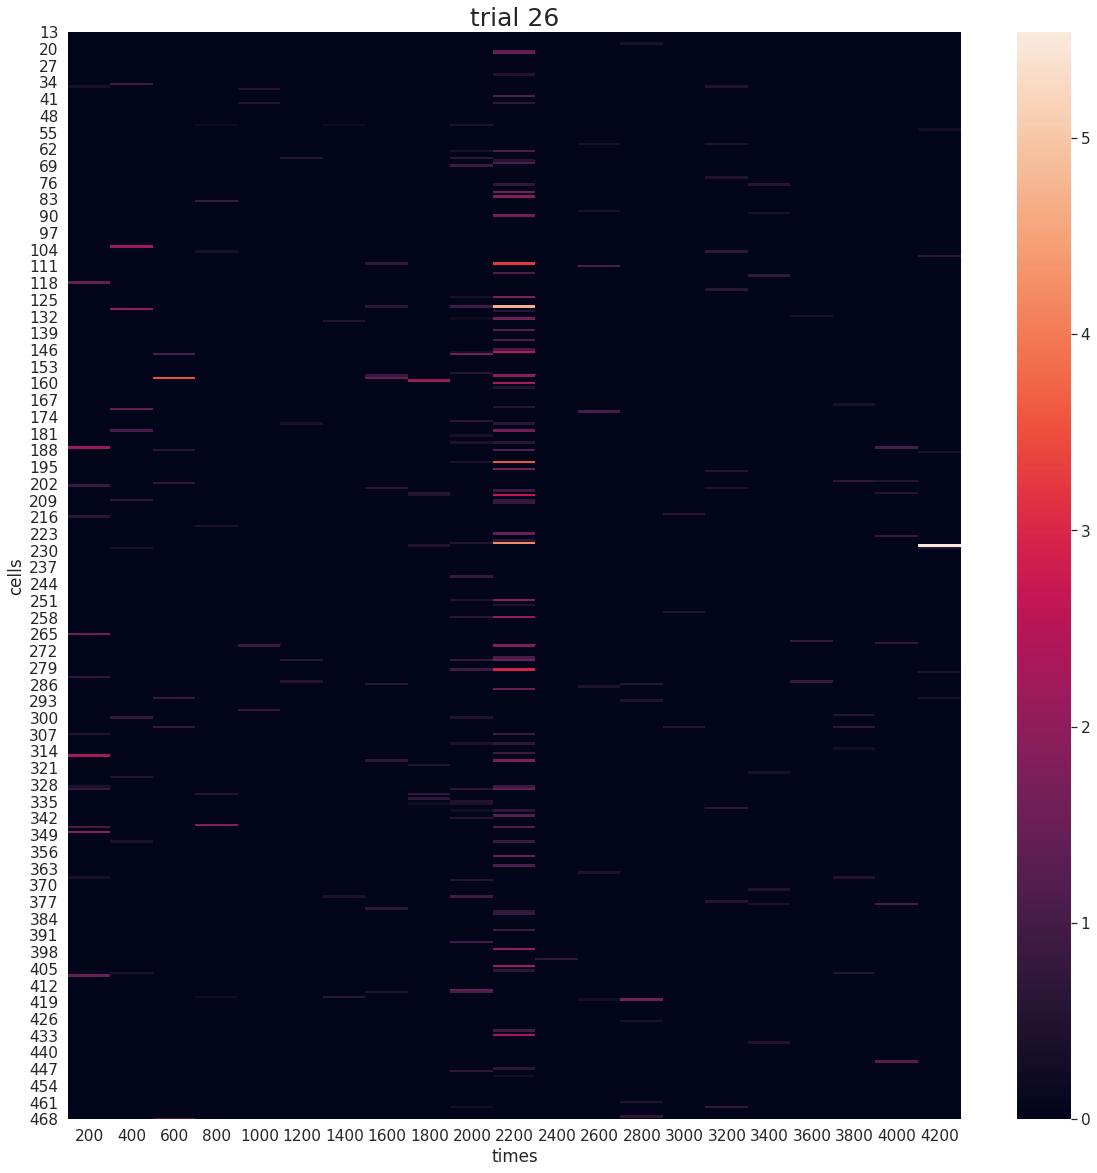

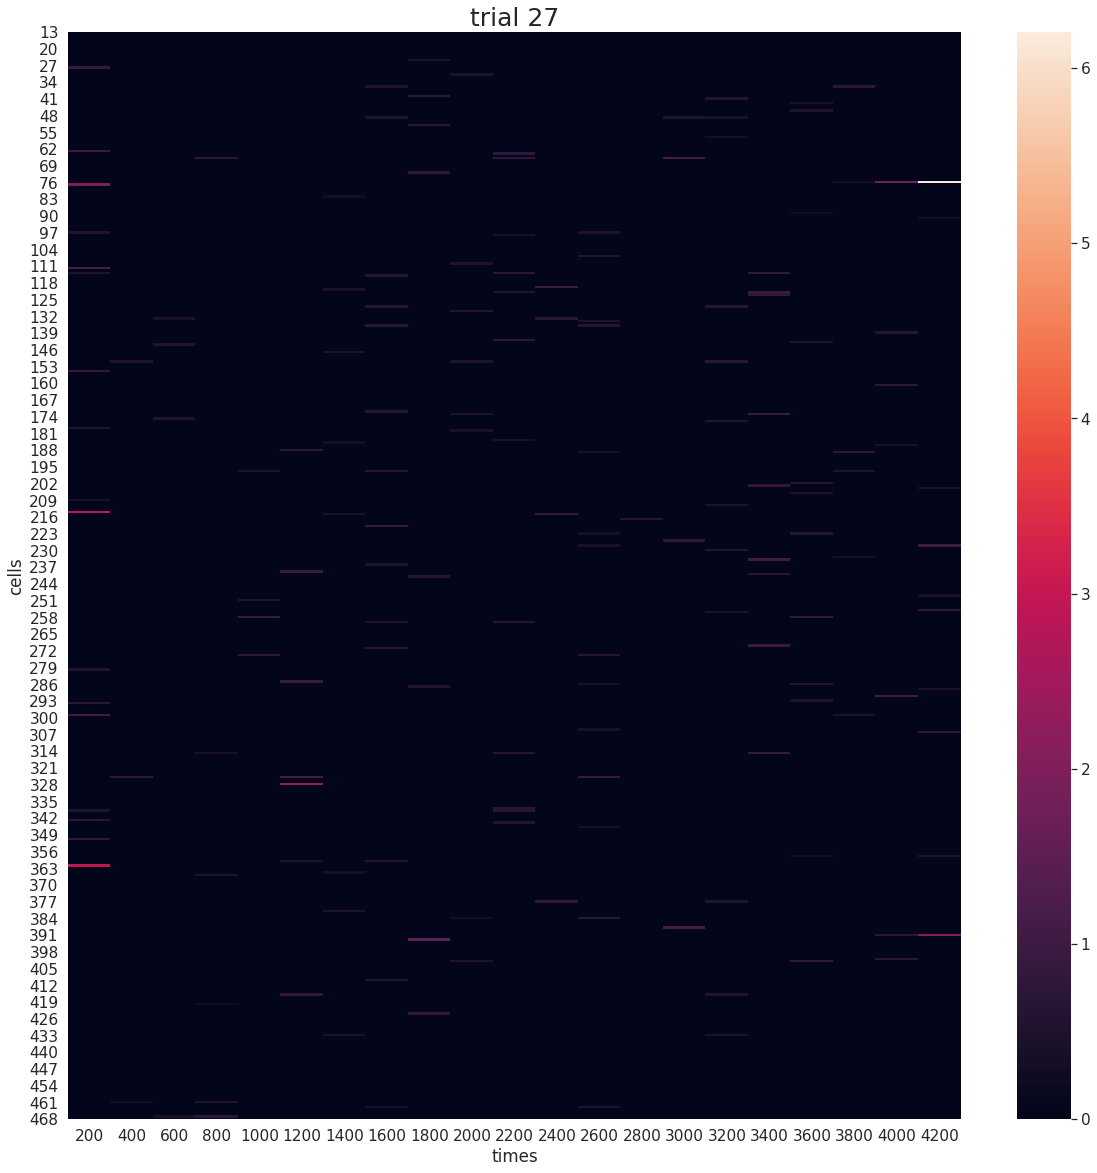

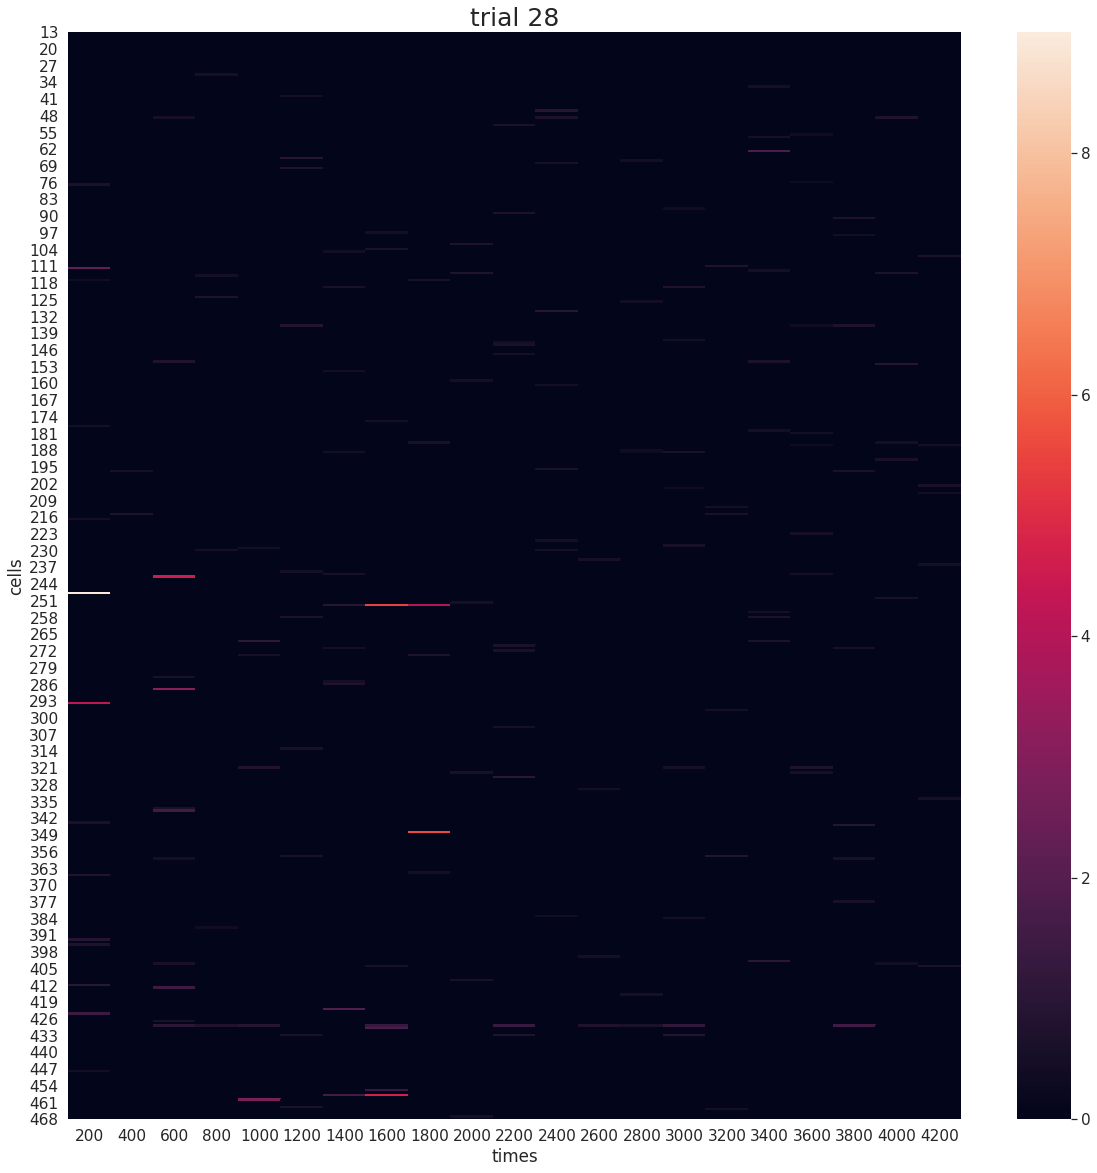

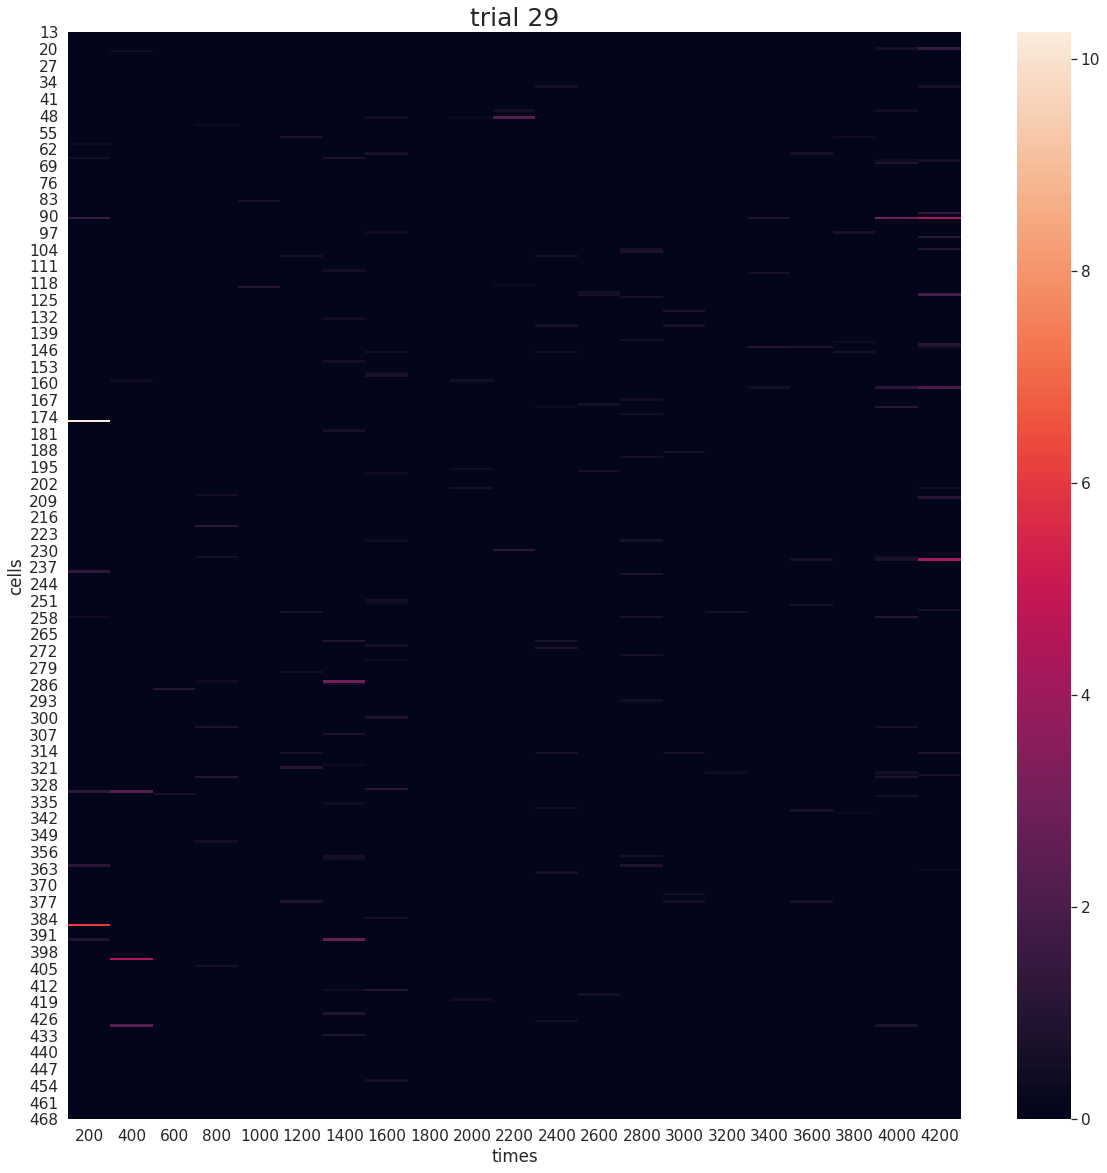

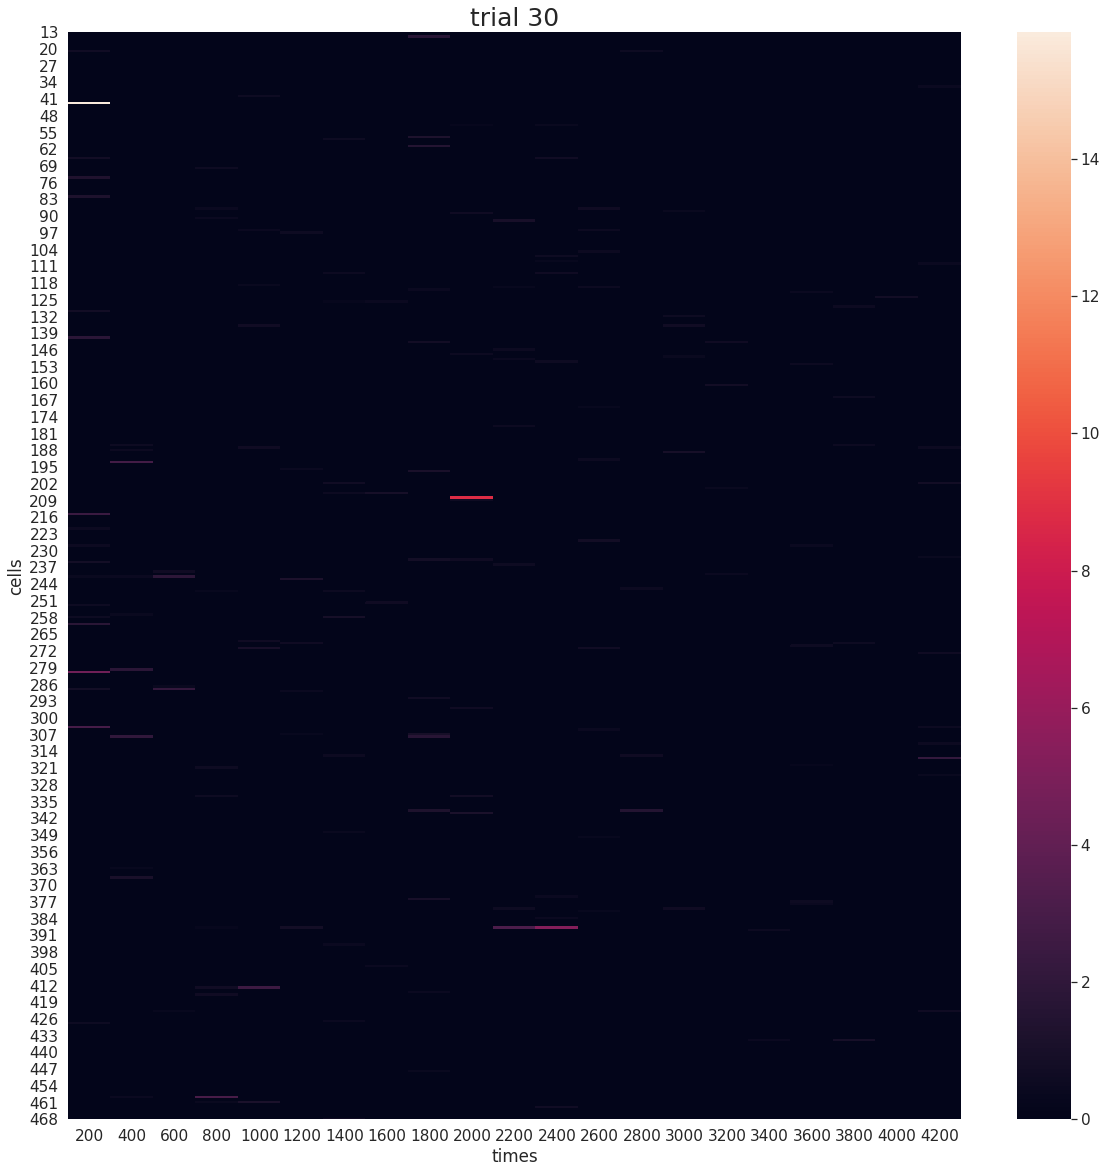

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import os 
#os.mkdir("./plots")
print("binned dic")

c=0
for trial,bin in binned_dic.items():
    #print("trial:", trial)
    times,cells,spikes = [],[],[]
    for time,activities in bin.items():
        #print("time:", time)
        for cell,v in activities.items():
            if cell<=12:  # to skip over behavior and metadata
                continue
            activity_sum = 0
            count = 0
            for x in v:
                activity_sum += x
                count += 1
            mean_activity = activity_sum / count
            #print("time:", time, "cell:", cell, "mean_act:", mean_activity)
            times.append(time)
            cells.append(cell)
            spikes.append(mean_activity)
    data_dic = {}
    data_dic["times"] = times
    data_dic["cells"] = cells
    data_dic["spikes"] = spikes

    df = pd.DataFrame.from_dict(data_dic)
    df = df.pivot(index='cells', columns='times', values='spikes')
    print(df.head())
    fig, ax = plt.subplots(figsize=(20,20)) 
    plt.title("trial "+str(trial))
    sns.heatmap(df, annot=False)
    plt.savefig("plots/trial"+str(trial)+".png")